# The Effects of a Changing Environment on the Spectra of Mars Analog Samples

This work constitutes the data analysis section for my MSc thesis at UCL (currently in progress, due August 2024). My project is advised by Dr Louisa Preston, with support from Professor Lewis Dartnell and Connor Ballard.

In this notebook, I will be analysing how lyophilization affects the spectra of Mars analog samples. This analysis includes:

* Mid-IR spectra collected at the Mullard Space Science Laboratory using the Agilent 4300 Handheld FTIR spectrometer, docked onto a table-top setup and equipped with a Diamond-ATR sampling module.
* Vis-NIR spectra collected at the University of Westminster using the RxSpec 700Z spectrometer. There are spectral joins in this data at $1000cm^{-1}$ and $1830cm^{-1}$, so features around these wavenumbers should be disregarded in analysis. 

In [838]:
import numpy as np
import matplotlib.pyplot as plt
from os import listdir
from scipy.signal import find_peaks

## Samples

I am analysing sandstone from Antarctica (denoting Antarctica crytoendolith sandstone as ACE SST) and <a href="https://doi.org/10.1016/j.icarus.2023.115568">SOPHIA</a> (Simulant for Oxia Planum: Hydrated, Igneous, and Amorphous). I also analyse the spectra for a microbial mat collected on the Robert Falcon Scott expedition to Antarctica in 1910. For the SOPHIA sample, I analyse the spectra with and without microbes from the mat mixed in. For each sample, I collected multiple spectra to analyse different parts of the sample. These are labeled as subsamples (SS). I label the samples as: 

* ACE SST BP5 - crustal layer of Antarctica sandstone sample from site BP5
* ACE SST BP6 - crustal layer of Antarctica sandstone sample from site BP6
* ACE SST BLACK - black layer of Antarctica sandstone sample
* SCOTT MAT - microbial mat from the Scott expedition
* SOPHIA - simulant
* SOPHIA MAT - simulant with microbial mat mixed in

In [839]:
DATA_ROOT = './Data'
DATA_BEFORE = DATA_ROOT + '/BEFORE LYO'
DATA_AFTER = DATA_ROOT + '/AFTER LYO'
DATA_MIR = '/MID IR'
DATA_VIS_NIR = '/VIS NIR'
DATA_ACE_SST_BP5 = '/ACE SST BP5'
DATA_ACE_SST_BP6 = '/ACE SST BP6'
DATA_ACE_SST_BLACK = '/ACE SST BLACK'
DATA_SCOTT_MAT = '/SCOTT MAT'
DATA_SOPHIA = '/SOPHIA'
DATA_SOPHIA_MAT = '/SOPHIA MAT'

DATA_MIR_BEFORE = DATA_BEFORE + DATA_MIR
DATA_MIR_AFTER = DATA_AFTER + DATA_MIR
DATA_VIS_NIR_BEFORE = DATA_BEFORE + DATA_VIS_NIR
DATA_VIS_NIR_AFTER = DATA_AFTER + DATA_VIS_NIR

DATA_SKIP_ROWS_MIR_BEFORE=1
DATA_SKIP_FOOTER_MIR_BEFORE=0
DATA_SKIP_ROWS_MIR_AFTER=1
DATA_SKIP_FOOTER_MIR_AFTER=0
DATA_SKIP_ROWS_VIS_NIR_BEFORE=1
DATA_SKIP_FOOTER_VIS_NIR_BEFORE=0
DATA_SKIP_ROWS_VIS_NIR_AFTER=1
DATA_SKIP_FOOTER_VIS_NIR_AFTER=0

STYLE_BEFORE = '-'
STYLE_AFTER = '--'
SAMPLE_COLORS_BEFORE = {
    'ACE SST BP5': 'DarkSlateBlue',
    'ACE SST BP6': 'MediumVioletRed',
    'ACE SST BLACK': 'Black',
    'SCOTT MAT': 'ForestGreen',
    'SOPHIA': 'SaddleBrown',
    'SOPHIA MAT': 'FireBrick',
}
SAMPLE_COLORS_AFTER = {
    'ACE SST BP5': 'CornflowerBlue',
    'ACE SST BP6': 'LightCoral',
    'ACE SST BLACK': 'LightSlateGrey',
    'SCOTT MAT': 'SpringGreen',
    'SOPHIA': 'SandyBrown',
    'SOPHIA MAT': 'Crimson',
}

In [840]:
def load_spectra(fileName):
    delimiter = '\t'
    if (fileName.endswith('.csv')):
        delimiter = ','

    skiprows = 0
    skipfooter = 0
    if (DATA_MIR_BEFORE in fileName):
        skiprows = DATA_SKIP_ROWS_MIR_BEFORE
        skipfooter = DATA_SKIP_FOOTER_MIR_BEFORE
    elif (DATA_MIR_AFTER in fileName):
        skiprows = DATA_SKIP_ROWS_MIR_AFTER
        skipfooter = DATA_SKIP_FOOTER_MIR_AFTER
    elif (DATA_VIS_NIR_BEFORE in fileName):
        skiprows = DATA_SKIP_ROWS_VIS_NIR_BEFORE
        skipfooter = DATA_SKIP_FOOTER_VIS_NIR_BEFORE
    elif (DATA_VIS_NIR_AFTER in fileName):
        skiprows = DATA_SKIP_ROWS_VIS_NIR_AFTER
        skipfooter = DATA_SKIP_FOOTER_VIS_NIR_AFTER

    result = np.loadtxt(fileName, delimiter=delimiter, skiprows=skiprows)
    result = np.transpose(result)

    if (skipfooter != 0):
        result = [result[0][0:-skipfooter], result[1][0:-skipfooter]]

    return result

In [841]:
def load_selected_spectra(dir, ss):
    subsample = listdir(dir)[ss - 1]

    return load_spectra(fileName=dir + '/' + subsample)

In [842]:
def load_subsamples_spectra(dir):
    result = {}

    for sample in listdir(dir):
        result[sample] = []
        
        for subsample in listdir(dir + '/' + sample):
            result[sample].append(load_spectra(fileName=dir + '/' + sample + '/' + subsample))

    return result

In [843]:
BEFORE_MIR = load_subsamples_spectra(dir=DATA_MIR_BEFORE)
AFTER_MIR = load_subsamples_spectra(dir=DATA_MIR_AFTER)
BEFORE_VIS_NIR = load_subsamples_spectra(dir=DATA_VIS_NIR_BEFORE)
AFTER_VIS_NIR = load_subsamples_spectra(dir=DATA_VIS_NIR_AFTER)

SELECTED_SUBSAMPLES = {
    'BEFORE_MIR': {
        'ACE_SST_BP5': None,
        'ACE_SST_BP6': None,
        'ACE_SST_BLACK': None,
        'SCOTT_MAT': None,
        'SOPHIA': None,
        'SOPHIA_MAT': None,
    },
    'AFTER_MIR': {
        'ACE_SST_BP5': None,
        'ACE_SST_BP6': None,
        'ACE_SST_BLACK': None,
        'SCOTT_MAT': None,
        'SOPHIA': None,
        'SOPHIA_MAT': None,
    },
    'BEFORE_VIS_NIR': {
        'ACE_SST_BP5': None,
        'ACE_SST_BP6': None,
        'ACE_SST_BLACK': None,
        'SCOTT_MAT': None,
        'SOPHIA': None,
        'SOPHIA_MAT': None,
    },
    'AFTER_VIS_NIR': {
        'ACE_SST_BP5': None,
        'ACE_SST_BP6': None,
        'ACE_SST_BLACK': None,
        'SCOTT_MAT': None,
        'SOPHIA': None,
        'SOPHIA_MAT': None,
    },
}

## Plotting Functions

In [844]:
def get_color(sample, isBefore, showAll):
    if (showAll):
        return None
    
    if (isBefore):
        return SAMPLE_COLORS_BEFORE[sample]
        
    return SAMPLE_COLORS_AFTER[sample]

In [845]:
def get_linestyle(isBefore):
    if (isBefore):
        return STYLE_BEFORE
        
    return STYLE_AFTER

In [846]:
def get_subsamples(sample, isMIR, isBefore):
    if (isMIR):
        if (isBefore):
            return BEFORE_MIR[sample]
        
        return AFTER_MIR[sample]
    
    if (isBefore):
        return BEFORE_VIS_NIR[sample]
        
    return AFTER_VIS_NIR[sample]  

In [847]:
def get_selected_subsample(sample, isMIR, isBefore):
    if (isMIR):
        if (isBefore):
            return SELECTED_SUBSAMPLES['BEFORE_MIR'][sample]
        
        return SELECTED_SUBSAMPLES['AFTER_MIR'][sample]
    
    if (isBefore):
        return SELECTED_SUBSAMPLES['BEFORE_VIS_NIR'][sample]
        
    return SELECTED_SUBSAMPLES['AFTER_VIS_NIR'][sample]

In [848]:
def get_title(sample, isMIR, isBefore):
    result = sample + ': '

    if (isMIR):
        result += 'MIR '
    else:
        result += 'Vis-NIR '

    if (isBefore):
        result += 'Before '
    else:
        result += 'After '

    result += 'Lyophilization'

    return result

In [849]:
def create_figure(title, isMIR):
    xlabel = 'Wavelength ($nm$)'
    ylabel = 'Reflectance'
    if (isMIR):
        xlabel = 'Wavenumber ($cm^{-1}$)'
        ylabel = 'Absorbance'
    
    fig, ax = plt.subplots()

    ax.set_title(title)
    ax.set(xlabel=xlabel, ylabel=ylabel)

    if (isMIR):
        ax.invert_xaxis()

    return fig, ax

In [850]:
def plot_sample(sample, isMIR, isBefore, showAll=False, prominence=None):
    color = get_color(sample, isBefore, showAll)
    linestyle = get_linestyle(isBefore)
    data = get_subsamples(sample, isMIR, isBefore)
    if (not showAll):
        data = [data[get_selected_subsample(sample, isMIR, isBefore) - 1]]

    title = get_title(sample=sample, isBefore=isBefore, isMIR=isMIR)
    fig, ax = create_figure(title=title, isMIR=isMIR)

    for i in range(len(data)):
        ax.plot(data[i][0], data[i][1], color=color, linestyle=linestyle, label='SS ' + str(i + 1))

        if (prominence != None):
            peaks, _ = find_peaks(data[i][1], prominence=prominence)
            ax.plot(data[i][0][peaks], data[i][1][peaks], 'x')
            print(data[i][0][peaks])
    
    if (len(data) > 1):
        ax.legend()

    # fig.savefig('./Spectra/' + title + '/' + sample + '.png')

In [851]:
def compare_subsamples(sample_A, isMIR, sample_A_isBefore, sample_B=None, sample_B_isBefore=None, sample_C=None, sample_C_isBefore=None):
    if ((sample_A_isBefore == False and sample_B_isBefore == True) or (sample_A_isBefore == True and sample_B_isBefore == False)):
        raise Exception('Only compare samples both before or both after lyophilization')

    if (sample_B == None):
        sample_B = sample_A
        sample_B_isBefore = not sample_A_isBefore
        title = sample_A + ' Lyophilization Effects'
        labelA = 'Before'
        labelB = 'After'
    else:
        title = sample_A + ' vs. ' + sample_B
        if (sample_C):
            title += ' vs. ' + sample_C

        if (sample_A_isBefore and sample_B_isBefore):
            title += ' Before Lyophilization'
        else:
            title += ' After Lyophilization'
                    
        labelA = sample_A
        labelB = sample_B

    sample_A_selected = get_selected_subsample(sample_A, isMIR, sample_A_isBefore) - 1
    subsample_A = get_subsamples(sample_A, isMIR, sample_A_isBefore)[sample_A_selected]

    sample_B_selected = get_selected_subsample(sample_B, isMIR, sample_B_isBefore) - 1
    subsample_B = get_subsamples(sample_B, isMIR, sample_B_isBefore)[sample_B_selected]
    
    fig, ax = create_figure(title=title, isMIR=isMIR)

    ax.plot(subsample_A[0], subsample_A[1], color=get_color(sample_A, sample_A_isBefore, showAll=False), linestyle=get_linestyle(sample_A_isBefore), label=labelA)
    ax.plot(subsample_B[0], subsample_B[1], color=get_color(sample_B, sample_B_isBefore, showAll=False), linestyle=get_linestyle(sample_B_isBefore), label=labelB)

    if (sample_C):
        sample_C_selected = get_selected_subsample(sample_C, isMIR, sample_C_isBefore) - 1
        subsample_C = get_subsamples(sample_C, isMIR, sample_C_isBefore)[sample_C_selected]

        ax.plot(subsample_C[0], subsample_C[1], color=get_color(sample_C, sample_C_isBefore, showAll=False), linestyle=get_linestyle(sample_C_isBefore), label=sample_C)

    ax.legend()
    
#     fig.savefig('./Spectra/' + title + '/' + sample + '.png')

## MID IR Analysis

When choosing the subsample to analyse, I made sure not to exclude any subsamples that displayed interesting features not present in the selected sample. 

For MIR, the choice of subsample usually came down to the one with the best Signal-to-Noise Ratio (SNR) and most prominent features, to reduce the fuzziness in the spectra and make analysis easier.

### Before Lyophilization 

In [852]:
def plot_mir_before(sample, showAll=False, prominence=None):
    plot_sample(sample=sample, isMIR=True, isBefore=True, showAll=showAll, prominence=prominence)

#### ACE SST BP5

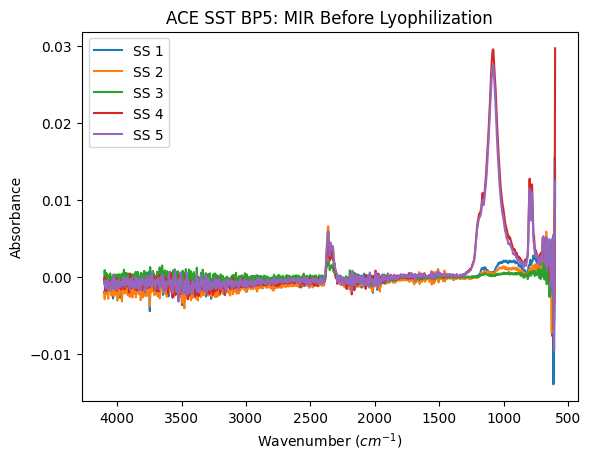

In [853]:
plot_mir_before(sample='ACE SST BP5', showAll=True)

Choosing SS 4 - higher SNR and more pronounced features than SS 5

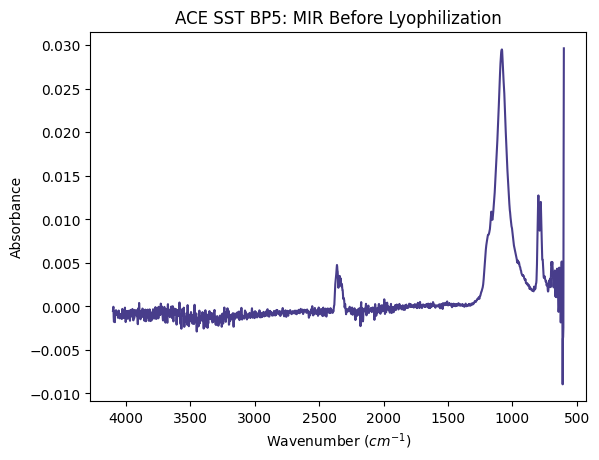

In [854]:
SELECTED_SUBSAMPLES['BEFORE_MIR']['ACE SST BP5'] = 4
plot_mir_before(sample='ACE SST BP5')

The SNR is not ideal in the sandstone samples due to difficulties establishing solid contact between the sample and the sampling window.

The strong peak at $1080cm^{-1}$ is characteristic of all forms of $SiO_2$, arising from the asymmetrical stretch of the $Si-O$ bonds. The sharp peak on the slope of the $1080cm^{-1}$ peak, the doublet peak at $800cm^{-1}$ and $780cm^{-1}$, and the peak at $695cm^{-1}$ (hard to decipher from the noise in this sample but seen more clearly in ACE SST BP6 and BLACK below) indicates that this is $\alpha$-quartz silica.

<a href="https://www.gelest.com/wp-content/uploads/5000A_Section1_InfraredAnalysis.pdf">There is no indication of organosilicon compounds in this sample.</a>

The $2350cm^{-1}$ peak is characteristic of $CO_2$, arising due to symmetric and asymmetric stretching of the $C=O$ linear bond. This strucutre is uncommon in other molecules, so the likely cause of this peak is carbon dioxide from the atmosphere. The background scans taken before the spectra were collected should subtract out any atmospheric effects, so the presence of these peaks may indicate issues with air circulation in the lab where the measurements were taken, which could change the levels of $CO_2$ in the air between the background and subsequent measurements. This could also explain the noise around $3400cm^{-1}$, which could arise from $OH$ bending from $H_2O$ molecules in the atmosphere.

#### ACE SST BP6

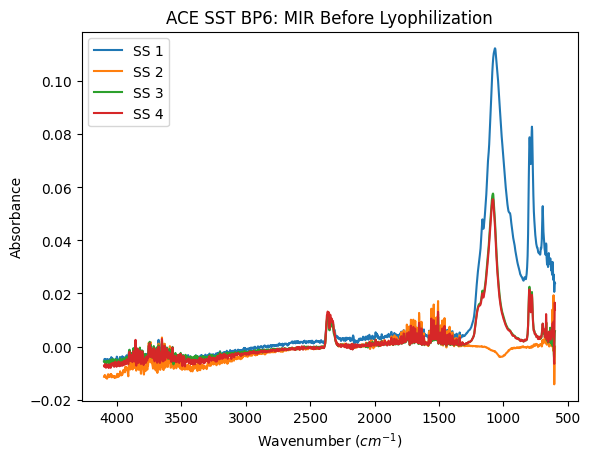

In [855]:
plot_mir_before(sample='ACE SST BP6', showAll=True)

Choosing SS 1 - higher SNR

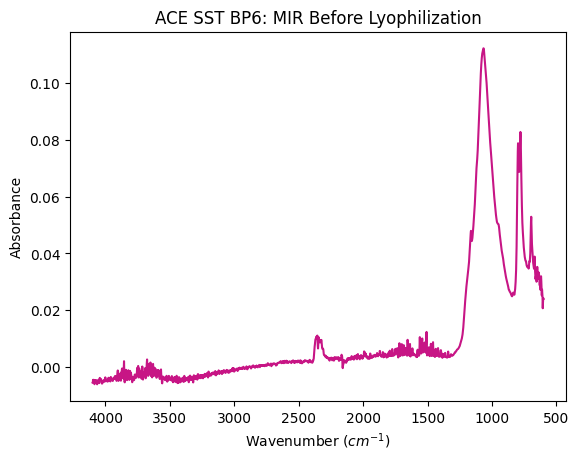

In [856]:
SELECTED_SUBSAMPLES['BEFORE_MIR']['ACE SST BP6'] = 1
plot_mir_before(sample='ACE SST BP6')

The spectra for BP6 show the same characteristic features as for BP5, which we expect, although we have managed to achieve a much higher SNR for this sample.

There is some noise in the $1300cm^{-1}$ to $1700cm^{-1}$ range, resembling two peaks on either side of $1500cm^{-1}$ that are consistent with the two peaks seen around $1318cm^{-1}$ and $1618cm^{-1}$ in the <a href="https://www.researchgate.net/figure/FT-IR-spectra-of-calcium-oxalate_fig2_301237664">spectra of calcium oxalate</a>, from $C=O$ and $C-O$ stretching respectively.

#### ACE SST BLACK

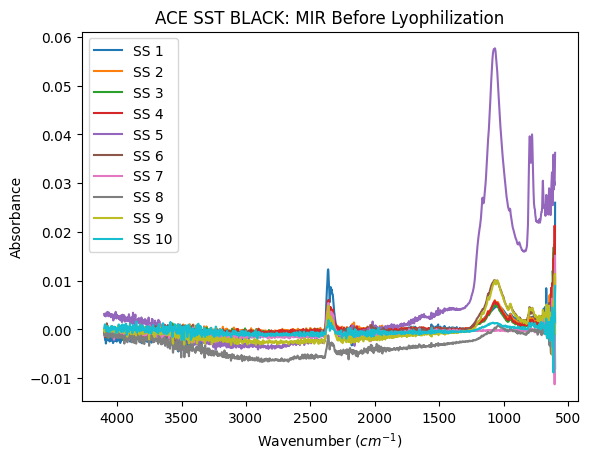

In [857]:
plot_mir_before(sample='ACE SST BLACK', showAll=True)

Choosing SS 5 - higher SNR

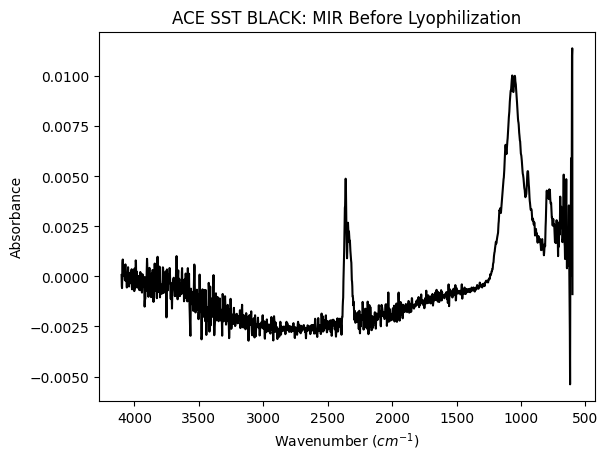

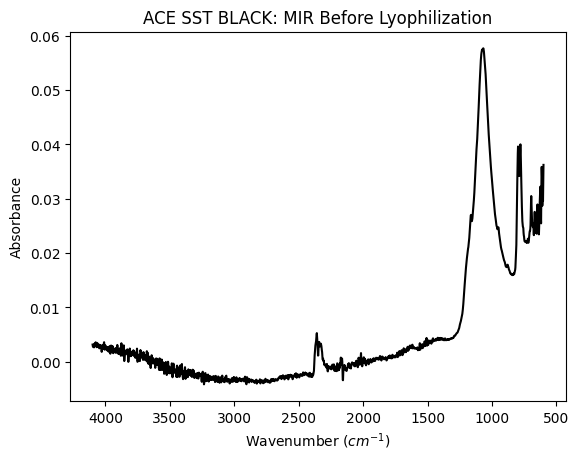

In [858]:
SELECTED_SUBSAMPLES['BEFORE_MIR']['ACE SST BLACK'] = 9
plot_mir_before(sample='ACE SST BLACK')

SELECTED_SUBSAMPLES['BEFORE_MIR']['ACE SST BLACK'] = 5
plot_mir_before(sample='ACE SST BLACK')

This sample shows largely the same features as BP5 and BP6, although there are two notable peaks at $880cm^{-1}$ and $950cm^{-1}$ on the slope of the $1080cm^{-1}$ peak. There are very small inidications of the $950cm^{-1}$ feature in the BP5 and BP6 samples, but here the peak is much more well-defined. These could arise from calcium oxalate, consistent with the features around $1318cm^{-1}$ and $1618cm^{-1}$, which <a href="https://analyticalsciencejournals.onlinelibrary.wiley.com/doi/epdf/10.1002/%28SICI%291097-4555%28199709%2928%3A9%3C685%3A%3AAID-JRS160%3E3.0.CO%3B2-X?saml_referrer">has been detected in similar samples</a>. Calcium oxalate is produced as a lichen by-product and this study found that dihydrate was only found in the upper, black portion of the lichen zone, whereas calcium oxalate monohydrate was found in the lower lichen zones and accumulation layer. They also found it was confined to the crustal and lichen zones, suggesting production by the microbial community from water and
not gained directly from the substrata.

The difference between calcium oxalate monohydrate and dihydrate can be determined by analysing the height of the $780cm^{-1}$ peak, as <a href="https://www.ncbi.nlm.nih.gov/pmc/articles/PMC9997882/">higher quantities of monohydrate result in a larger peak</a>.

TODO: look at peak heights in more detail. Might be hard to make a reliable comparison due to intensity changes for each subsample and masking/contributions from the SiO peak at the same wavenumber. Possible future work. Expect CaOx in the black layer, but why also in BP6? Need to find out more about exactly where all these samples are from - different locations, different layers etc.

<a href="https://www.cambridge.org/core/services/aop-cambridge-core/content/view/435A27C67907391C2CB8252AF52AD32C/S147355040400206Xa.pdf/biologically-induced-elemental-variations-in-antarctic-sandstones-a-potential-test-for-martian-micro-organisms.pdf">Kaolinite and illite found in similar samples</a>. <a href="https://www.researchgate.net/figure/Fourier-transform-infrared-spectroscopy-FTIR-spectra-of-the-illite-a-10-I-nZVI-b_fig1_335103739">Illite</a> shows peaks at $1398cm^{-1}$, $1628cm^{-1}$, and $690cm^{-1}$, and may also explain the presence of OH. Al-OH or Mg-OH bonds in in kaolinite or illite could explain the $950cm^{-1}$ and $695cm^{-1}$ peaks.

The ACE SST spectra are dominated by silica, which is consistent with previous studies of the beacon supergroup. Other compounds are difficult to determine with confidence, but the proposed options are also consistent with compunds found in the region. Vis-NIR analysis may provide more insight to complement this analysis.

#### SCOTT MAT

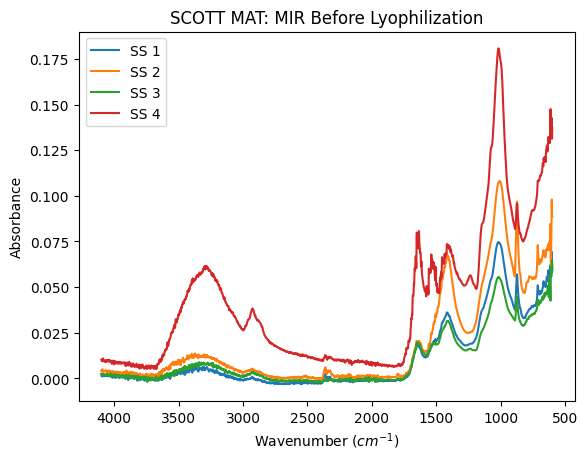

In [859]:
plot_mir_before(sample='SCOTT MAT', showAll=True)

Choosing SS 1 - more pronounced features, particularly at lower wavenumbers, but SS 4 displays a much stronger peak around $1500cm^{-1}$.

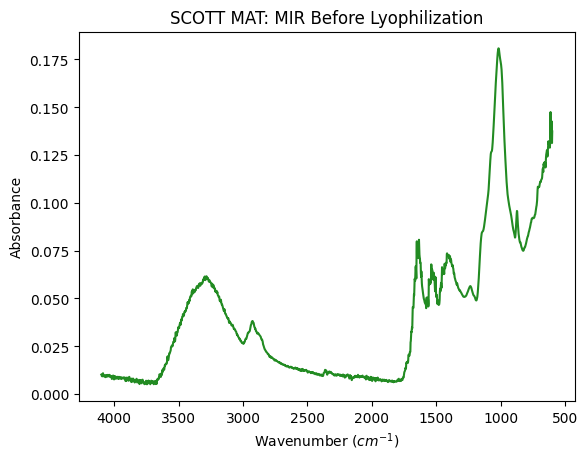

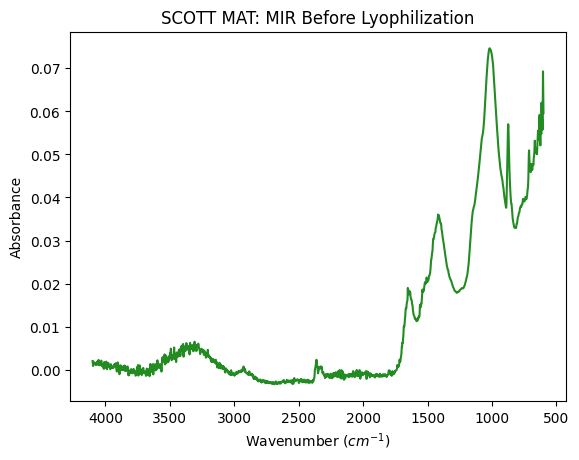

In [860]:
SELECTED_SUBSAMPLES['BEFORE_MIR']['SCOTT MAT'] = 4
plot_mir_before(sample='SCOTT MAT')

SELECTED_SUBSAMPLES['BEFORE_MIR']['SCOTT MAT'] = 1
plot_mir_before(sample='SCOTT MAT')

* $3000cm^{-1}$ - $3700cm^{-1}$: $O-H$ (water in cytoplasm, chlorophyll) and $N-H$ (proteins) stretching
* $2880cm^{-1}$ and $2925cm^{-1}$ doublet: $CH_2$ symmetric and asymmetric stretch (lipids, chlorophyll)
* $2350cm^{-1}$: $CO_2$ doublet
* $1653cm^{-1}$: amide I band $C=O$ stretch (proteins, $\beta$-pleated protein sheet structure, aldehyde in chlorophyll)
* $1540cm^{-1}$: amide II band $N-H$ bend and $C-N$ stretch (proteins)
* $1420cm^{-1}$: $CH_2$ and $CH_3$ bend at $1450cm^{-1}$ (polysaccharides, chlorophyll) or $O-H$ bending at $1410cm^{-1}$ (polysaccharides)
* $1235cm^{-1}$: $P=O$ asymmetric stretch (DNA)
* $1150cm^{-1}$: small, $C-O$ (cellulose)
* $1018cm^{-1}$: $C-O$ symmetric stretch (polysaccharides, chlorophyll)
* $874cm^{-1}$: $C-O$ stretch (polysaccharides, chlorophyll)
* $712cm^{-1}$: $CH_2$ rocking (lipids, chlorophyll)

Microbial mats typically consist of cyanobacteria in the upper layers and sulfate-reducing bacteria in the lower layers. The green appearance of the mat is due to chlorophyll-a, used by cyanobacteria to convert sunlight into chemical energy. The mats are held together and bound to their substrates by extracellular polymeric substance (EPS), which consist mostly of polysaccharides and proteins, but also include lipids and nucleic acids. The <a href="https://www.geeksforgeeks.org/cyanobacteria-structure-examples/">structure of cyanobacteria cells</a> is well-studied, so we can draw upon this to make more detailed inferences about where peaks arise in the spectra. Components in the cells are largely comprised of lipids, proteins, polysaccharides, and DNA, which explains many of the features present in the spectra.

<a href="https://www.researchgate.net/publication/330449151_Identification_and_Characterization_of_Some_Species_of_Cyanobacteria_Chlorophyta_and_BacillariophytaUsing_Fourier-Transform_Infrared_FTIR_Spectroscopy">Cyanobacteria peak assignments</a>

<a href="https://www.scirp.org/html/1-2270216_37921.htm">Cyanobacteria spectra</a>

<a href="https://spectrabase.com/spectrum/7zOxo8T5953">Chlorophyll a</a>: $C_{55}H_{72}MgN_4O_5$. CH2, CH3, Mg encased in chlorin (Mg-N bonds), C-N, C=N, C=O, C-O. Shows a peak at $1750cm^{-1}$ due to C=O that is not seen in the SCOTT MAT spectra. <a href="https://pubs.acs.org/doi/epdf/10.1021/ja01105a046">900, 800, 700 are characteristic of chlorophyll a.</a>

#### SOPHIA

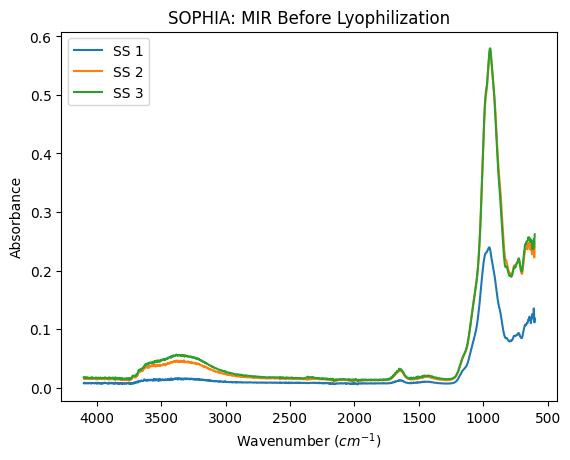

In [861]:
plot_mir_before(sample='SOPHIA', showAll=True)

Choosing SS 3 - higher SNR

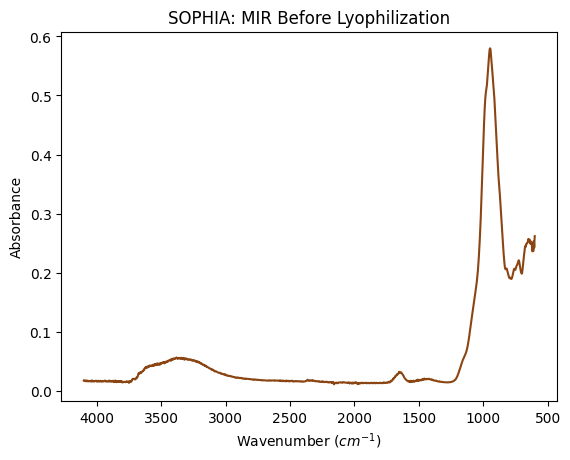

In [862]:
SELECTED_SUBSAMPLES['BEFORE_MIR']['SOPHIA'] = 3
plot_mir_before(sample='SOPHIA')

* $3400cm^{-1}$ - $O-H$ stretching from vermiculite.
* $1650cm^{-1}$ - $O-H$ stretching in <a href="https://www.researchgate.net/publication/262915474_Similarities_in_chemical_composition_of_soil_organic_matter_across_a_millennia-old_paddy_soil_chronosequence_as_revealed_by_advanced_solid-state_NMR_spectroscopy">phylosilicates</a>, $C=O$ stretching in siderite.
* $1460cm^{-1}$ - $O-H$ bending from phylosilicates, $Ca-O$ in plagioclase and augite.
* $950cm^{-1}$ - silicates. $Mg-O$ overtones from vermiculite and olivine. $Al-OH$ from phylosilicates.
* $800cm^{-1}$ - small broad peak from <a href="https://www.gelest.com/wp-content/uploads/5000A_Section1_InfraredAnalysis.pdf">amorphous silica</a>.
* $725cm^{-1}$ - $Mg-O$, $Fe-O$.
* $650cm^{-1}$ - $Fe-O$ stretch.

These assignments are based on the <a href="https://oro.open.ac.uk/88399/1/1-s2.0-S0019103523001458-main.pdf">SOPHIA mineralogy</a>:
* Phylosilicates ($40\%$)
    * Vermiculite ($26\%$): $(Mg, Fe^{2+}, Fe^{3+})_3[(Al, Si)_4O_{10}](OH)_24H_2O$. Si-O, Si-Al
    * Serpentine ($3\%$): $(Mg^{2+}, Fe^{2+}, Ni^{2+}, Mn^{2+}, Zn^{2+})_3Si_2O_5(OH)_4$.
    * Biotite ($2\%$): $K(Mg, Fe)_3(AlSi_3O_{10})(F, OH)_2$.
* Anhydrous minerals ($45\%$)
    * Plagioclase ($22\%$): $NaAlSi_3O_8 - CaAl_2Si_2O_8$.
    * Orthoclase ($3\%$): $KAlSi_3O_8$.
    * Pyroxene (Augite) ($15\%$): $(Ca, Na)(Mg, Fe, Al, Ti)(Si, Al)_2O_6$.
    * Olivine ($5\%$): $(Mg, Fe)_2SiO_4$.
* Anhydrous component ($11\%$)
    * Amorphous FeOOH ($1\%$)
    * Iron silicate ($10\%$): $Fe_2SiO_4$.
* Haematite ($1\%$): $Fe_2O_3$.
* Siderite ($2\%$): $FeCO_3$.

#### SOPHIA MAT

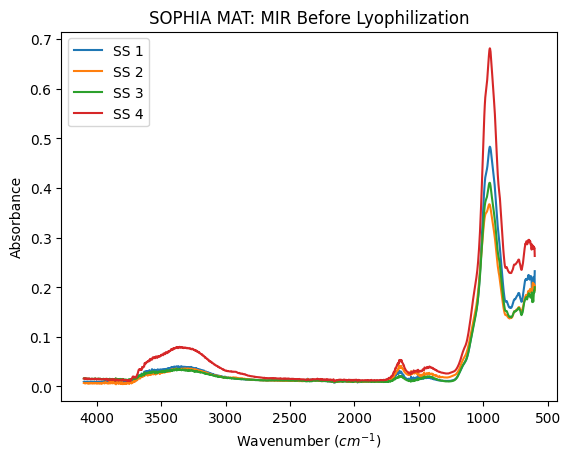

In [863]:
plot_mir_before(sample='SOPHIA MAT', showAll=True)

Choosing SS 4 - higher SNR

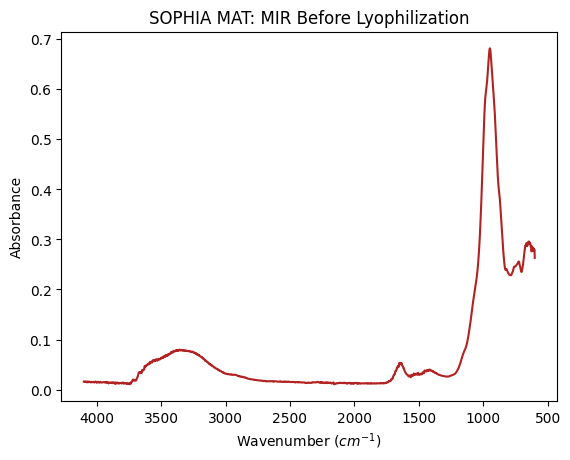

In [864]:
SELECTED_SUBSAMPLES['BEFORE_MIR']['SOPHIA MAT'] = 4
plot_mir_before(sample='SOPHIA MAT')

This looks very similar to the spectra of SOPHIA without the mat, which means that the simluant masks a lot of the organic features present in the mat. However, two notable expections are the small peak around $1530cm^{-1}$, which we assigned to Amide II vibrational modes of proteins, and a very small peak around $2900cm^{-1}$, which we assigned to stretching in $CH_2$. The $1530cm^{-1}$ peak did not show up in all subsamples for SCOTT MAT and only showed a strong presence in one subsample, so that should be considered when analysing the lyophilization effects.

### After Lyophilization

In [865]:
def plot_mir_after(sample, showAll=False):
    plot_sample(sample=sample, isMIR=True, isBefore=False, showAll=showAll)

#### ACE SST BP5

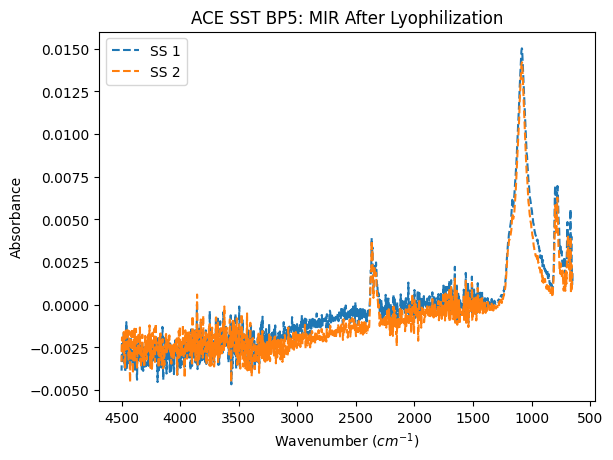

In [866]:
plot_mir_after(sample='ACE SST BP5', showAll=True)

Choosing SS 1 - slightly higher SNR

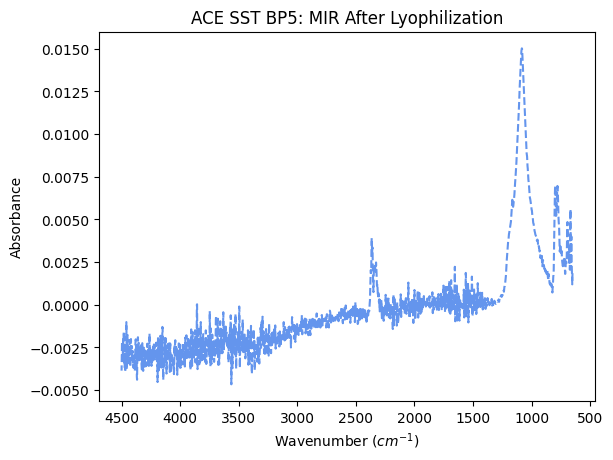

In [867]:
SELECTED_SUBSAMPLES['AFTER_MIR']['ACE SST BP5'] = 1
plot_mir_after(sample='ACE SST BP5')

#### ACE SST BP6

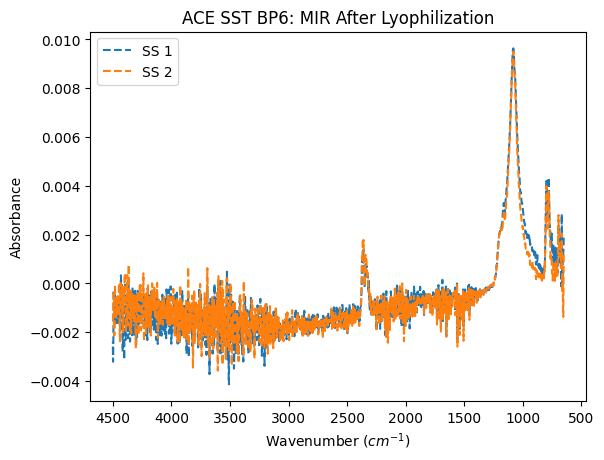

In [868]:
plot_mir_after(sample='ACE SST BP6', showAll=True)

Choosing SS 1 - possible features on the slope of the 1000 peak not seen in SS 2

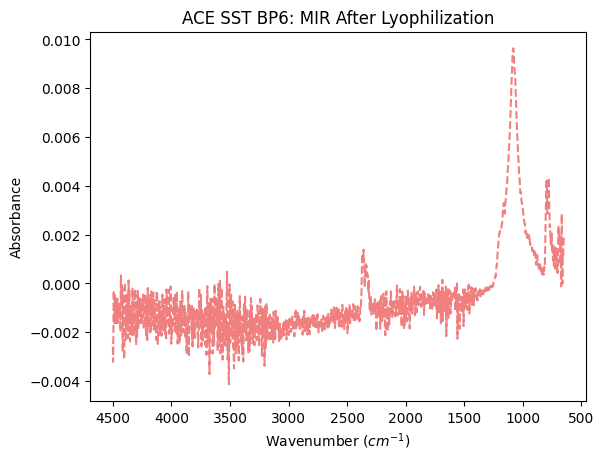

In [869]:
SELECTED_SUBSAMPLES['AFTER_MIR']['ACE SST BP6'] = 1
plot_mir_after(sample='ACE SST BP6')

#### ACE SST BLACK

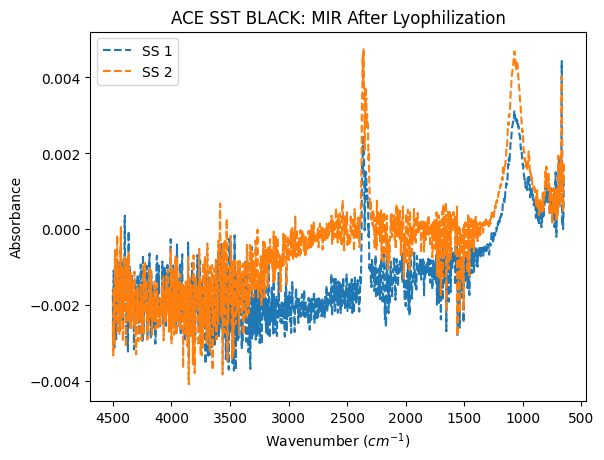

In [870]:
plot_mir_after(sample='ACE SST BLACK', showAll=True)

Choosing SS 2 - higher SNR and baseline lies closer to 0

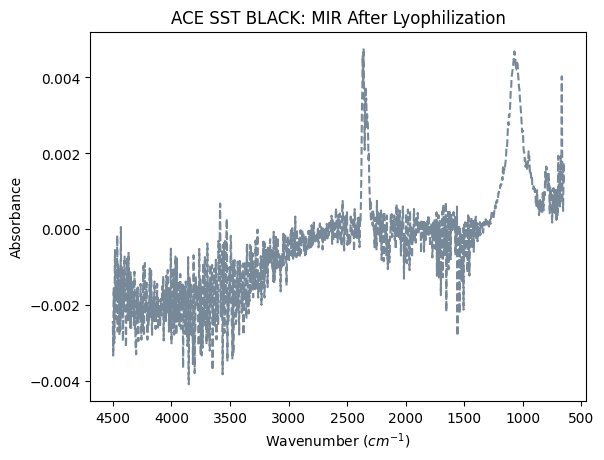

In [871]:
SELECTED_SUBSAMPLES['AFTER_MIR']['ACE SST BLACK'] = 2
plot_mir_after(sample='ACE SST BLACK')

#### SCOTT MAT

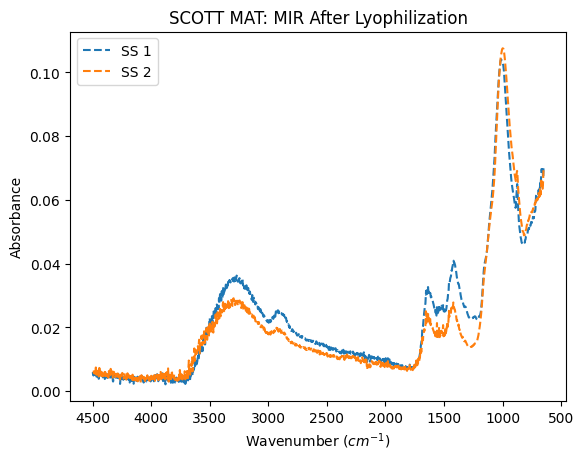

In [872]:
plot_mir_after(sample='SCOTT MAT', showAll=True)

Choosing SS 1 - higher SNR

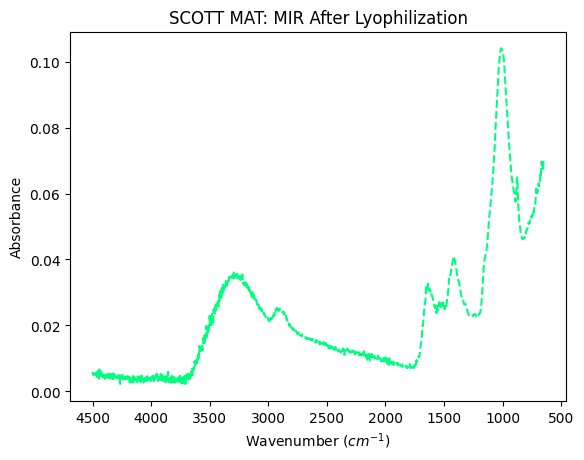

In [873]:
SELECTED_SUBSAMPLES['AFTER_MIR']['SCOTT MAT'] = 1
plot_mir_after(sample='SCOTT MAT')

#### SOPHIA

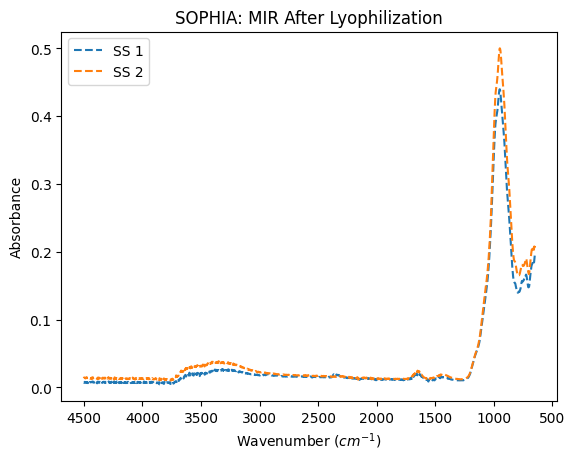

In [874]:
plot_mir_after(sample='SOPHIA', showAll=True)

Choosing SS 2 - higher SNR

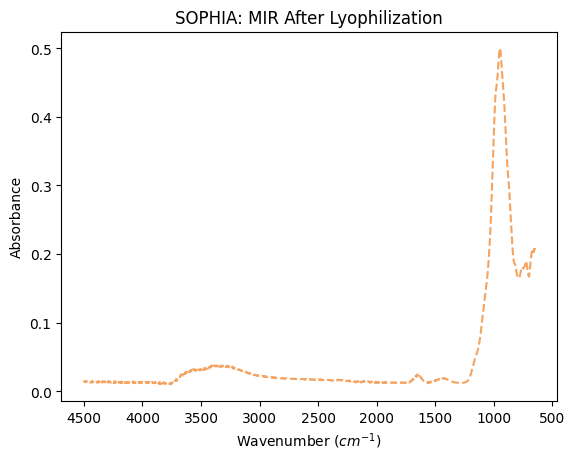

In [875]:
SELECTED_SUBSAMPLES['AFTER_MIR']['SOPHIA'] = 2
plot_mir_after(sample='SOPHIA')

#### SOPHIA MAT

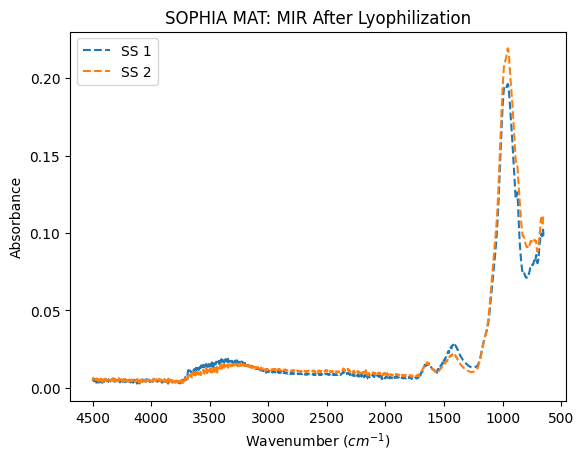

In [876]:
plot_mir_after(sample='SOPHIA MAT', showAll=True)

Choosing SS 1 - small feature on the slope of the 1000 peak that isn't visible in SS 2. SS 2 has better signal for the peaks at lower wavelengths, but these are still present in SS 1

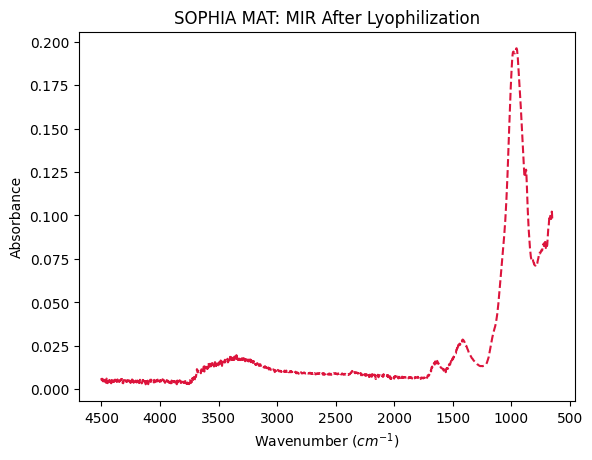

In [877]:
SELECTED_SUBSAMPLES['AFTER_MIR']['SOPHIA MAT'] = 1
plot_mir_after(sample='SOPHIA MAT')

### Lyophilization Effects

As a general comment, the spectra after lyophilization typically had a weaker signal (with the exception of the SCOTT MAT sample), but it is difficult to attribute thisto the lyophilization process with more data, as there was quite a lot of variance in the signal between each subsample, particularly for the ACE SST samples.

#### ACE SST BP5

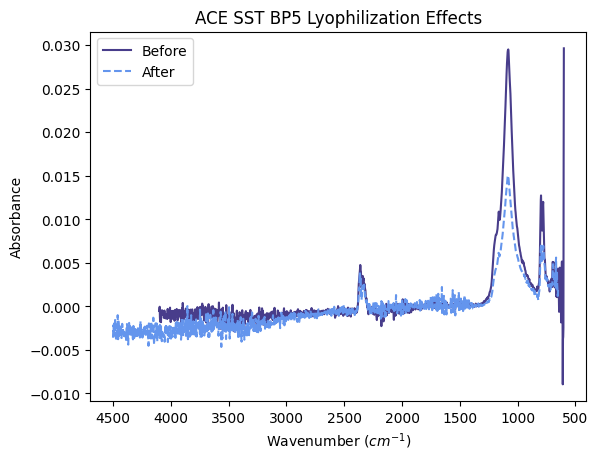

In [878]:
compare_subsamples(sample_A='ACE SST BP5', sample_A_isBefore=True, isMIR=True)

In general, lyophilization appears to have decreased the size of the peaks. There are no obvious differences in the features detected that we can detect, although the low SNR makes the comparison quite difficult.

#### ACE SST BP6

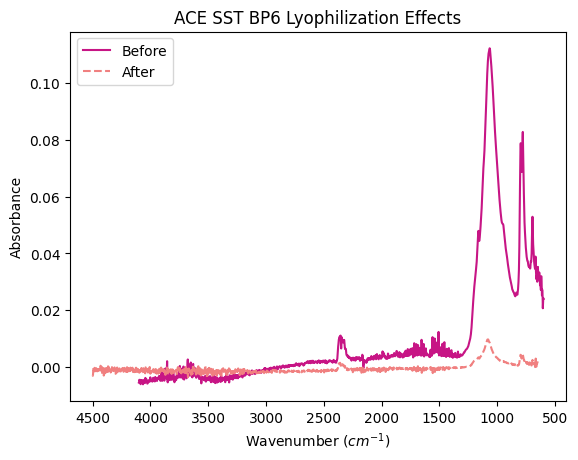

In [879]:
compare_subsamples(sample_A='ACE SST BP6', sample_A_isBefore=True, isMIR=True)

Similar to BP5, lyophilization in general has decreased the peak size. The peaks on the slope of the $1080cm^{-1}$ peak are more difficult to detect after lyophilization.

#### ACE SST BLACK

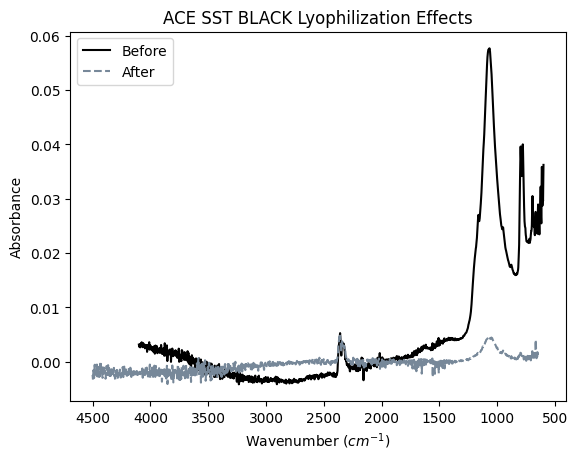

In [880]:
compare_subsamples(sample_A='ACE SST BLACK', sample_A_isBefore=True, isMIR=True)

As with the other ACE SST samples, the overall signal is lower. As with BP6, this makes some of the smaller peaks on the slope of the $1080cm^{-1}$ peak more difficult to detect after lyophilization.

#### SCOTT MAT

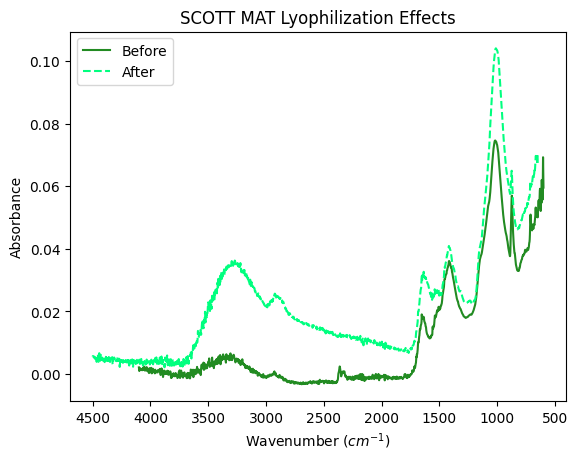

In [881]:
compare_subsamples(sample_A='SCOTT MAT', sample_A_isBefore=True, isMIR=True)

For this sample, we got a larger signal after the lyophilization process and a lot of the features were still present. However, at the lower wavenumbers the peaks show a significant decrease, such as the $712cm^{-1}$ peak assigned to $CH_2$ rocking.

We still see a strong $O-H$ peak after lyophilization, which suggests that a lot of the $o-H$ bonds are functional groups attached to compounds within the sample, rather than coming from water that would have sublimated during the lyophilization process.

#### SOPHIA

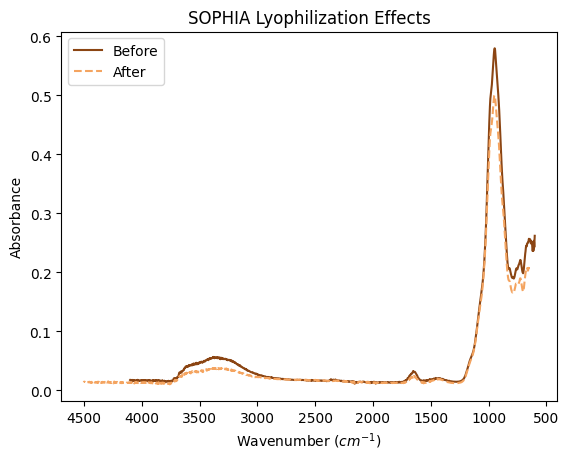

In [882]:
compare_subsamples(sample_A='SOPHIA', sample_A_isBefore=True, isMIR=True)

The spectra are almost identical for this sample, with a slight decrease in peak size after lyophilization.

#### SOPHIA MAT

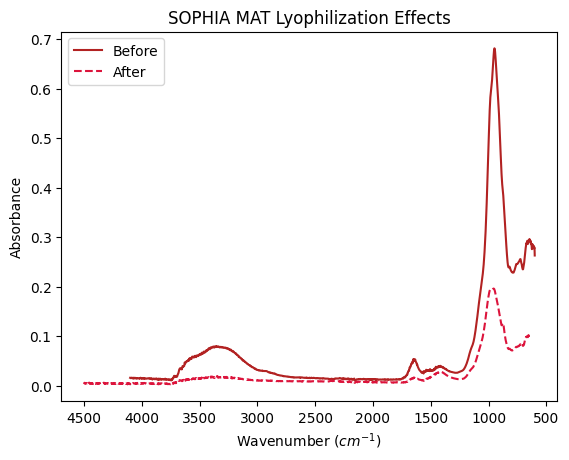

In [883]:
compare_subsamples(sample_A='SOPHIA MAT', sample_A_isBefore=True, isMIR=True)

The signal after lyophilization is smaller, in particular the $OH$ stretching at $3000cm^{-1} - 3700cm^{-1}$. The small peaks at $2900cm^{-1}$ ($CH_2$ stretching) and $1530cm^{-1}$ (amide II vibrational modes of proteins) are undetectable after lyophilzation. This suggests that the lyophilization process may hinder our ability to detect features related to some organic functional groups. However, the $1530cm^{-1}$ peak did not show up in all subsamples for SCOTT MAT and only showed a strong presence in one subsample before lyophilization, so more data would be useful to confirm that the lyophilization process is the reason for this peak not being present.

The $874cm^{-1}$ peak detected in the SCOTT MAT sample due to $C-O$ stretch was not present in the SOPHIA MAT sample before lyophilization, ut we see that this peak can be detected after the lyophilization process. This suggests that lyophilization may actually enable us to detect more organic features within minerals.

Further work is required to explore the reasons behind different peaks being visible before and after lyophilization and to confirm whether lyophilization is the cause of this. 

### ACE SST Analysis

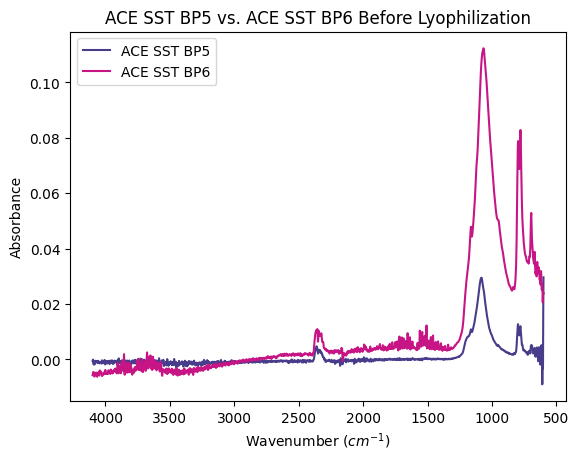

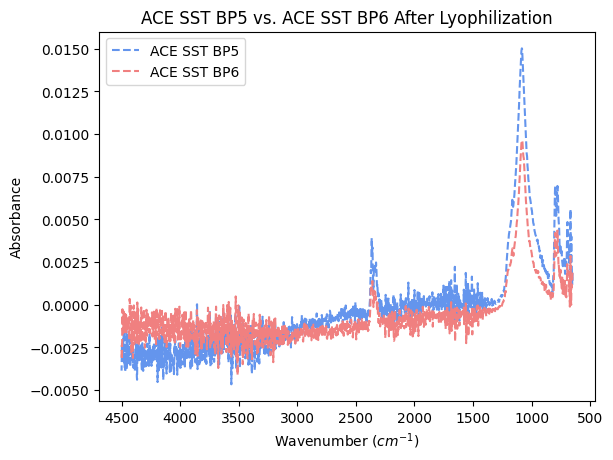

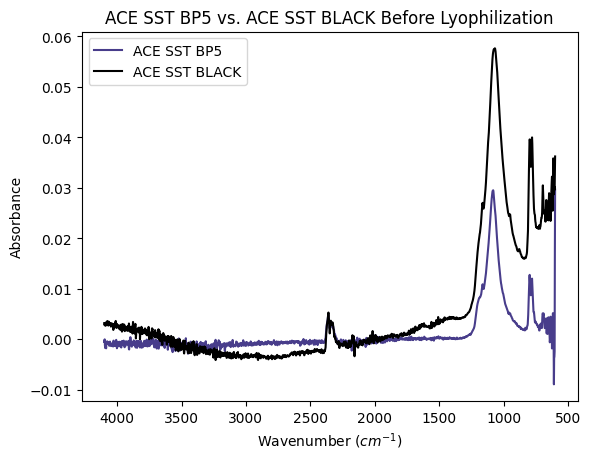

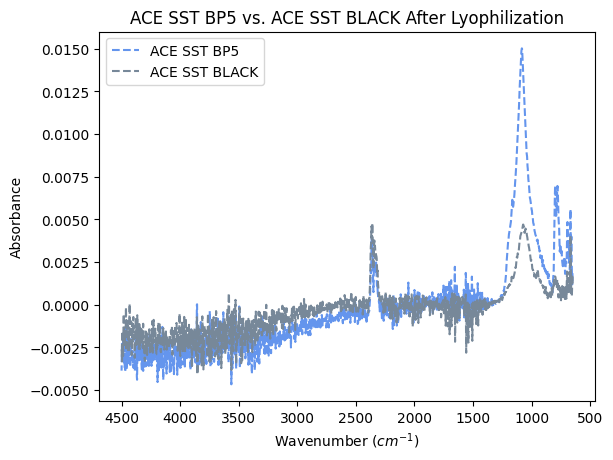

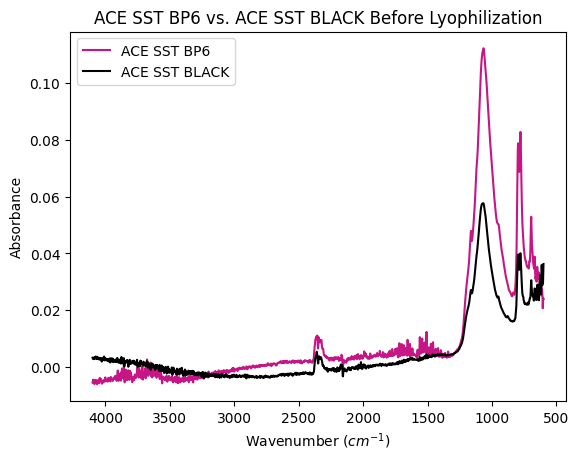

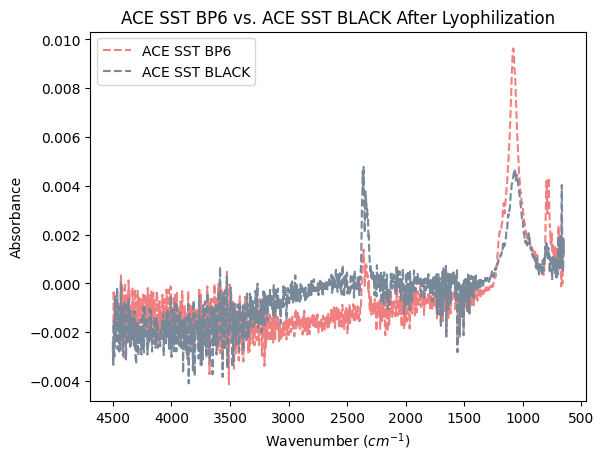

In [884]:
compare_subsamples(sample_A='ACE SST BP5', sample_B='ACE SST BP6', sample_A_isBefore=True, sample_B_isBefore=True, isMIR=True)
compare_subsamples(sample_A='ACE SST BP5', sample_B='ACE SST BP6', sample_A_isBefore=False, sample_B_isBefore=False, isMIR=True)
compare_subsamples(sample_A='ACE SST BP5', sample_B='ACE SST BLACK', sample_A_isBefore=True, sample_B_isBefore=True, isMIR=True)
compare_subsamples(sample_A='ACE SST BP5', sample_B='ACE SST BLACK', sample_A_isBefore=False, sample_B_isBefore=False, isMIR=True)
compare_subsamples(sample_A='ACE SST BP6', sample_B='ACE SST BLACK', sample_A_isBefore=True, sample_B_isBefore=True, isMIR=True)
compare_subsamples(sample_A='ACE SST BP6', sample_B='ACE SST BLACK', sample_A_isBefore=False, sample_B_isBefore=False, isMIR=True)

### SOPHIA Analysis

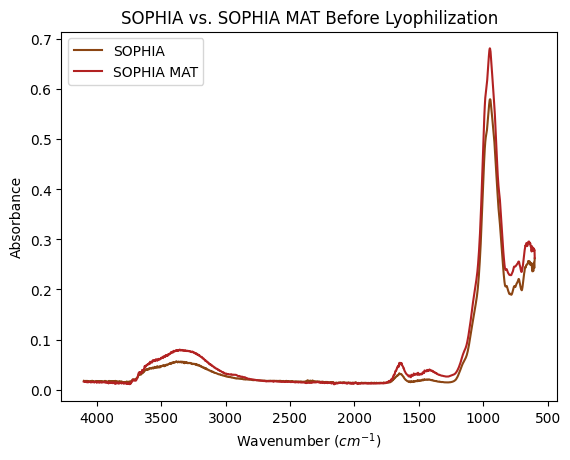

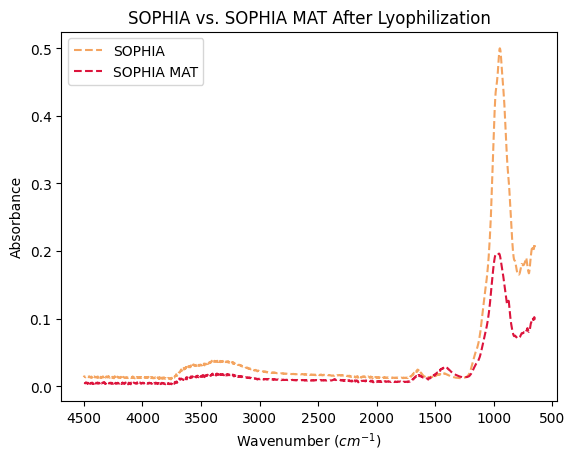

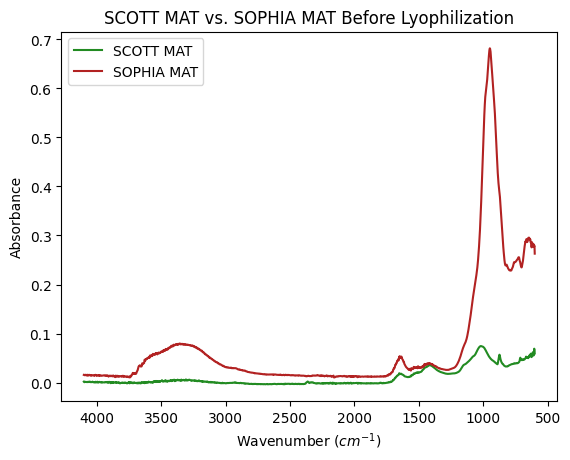

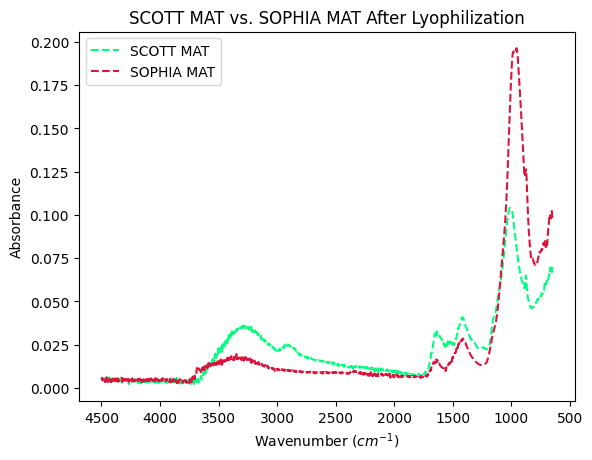

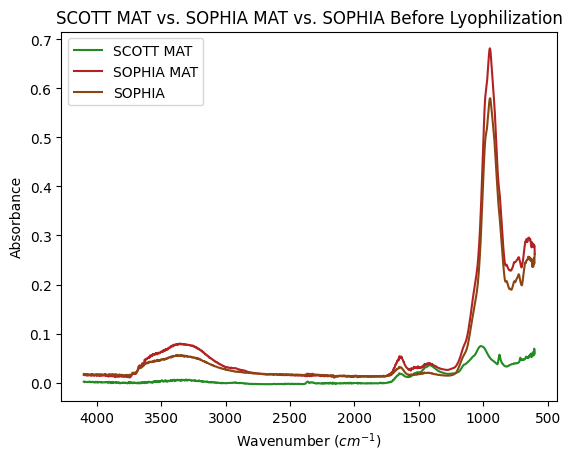

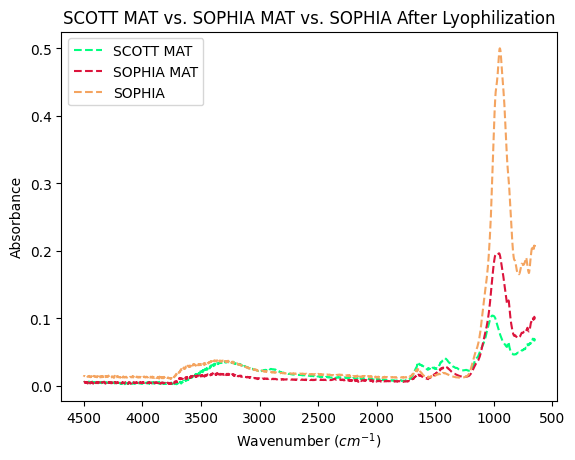

In [885]:
compare_subsamples(sample_A='SOPHIA', sample_B='SOPHIA MAT', sample_A_isBefore=True, sample_B_isBefore=True, isMIR=True)
compare_subsamples(sample_A='SOPHIA', sample_B='SOPHIA MAT', sample_A_isBefore=False, sample_B_isBefore=False, isMIR=True)
compare_subsamples(sample_A='SCOTT MAT', sample_B='SOPHIA MAT', sample_A_isBefore=True, sample_B_isBefore=True, isMIR=True)
compare_subsamples(sample_A='SCOTT MAT', sample_B='SOPHIA MAT', sample_A_isBefore=False, sample_B_isBefore=False, isMIR=True)
compare_subsamples(sample_A='SCOTT MAT', sample_B='SOPHIA MAT', sample_C='SOPHIA', sample_A_isBefore=True, sample_B_isBefore=True, sample_C_isBefore=True, isMIR=True)
compare_subsamples(sample_A='SCOTT MAT', sample_B='SOPHIA MAT', sample_C='SOPHIA', sample_A_isBefore=False, sample_B_isBefore=False, sample_C_isBefore=False, isMIR=True)

## VIS-NIR Analysis

When choosing the subsample to analyse, I made sure not to exclude any subsamples that displayed interesting features not present in the selected sample.

For Vis-NIR, the choice of subsample usually came down to the one that was least affected by spectral joins. However, there were a couple of subsamples that were selected because there were inidications of small features that were not present in all (or any) other subsamples.

### Before Lyophilization

In [886]:
def plot_vis_nir_before(sample, showAll=False):
    plot_sample(sample=sample, isMIR=False, isBefore=True, showAll=showAll)

#### ACE SST BP5

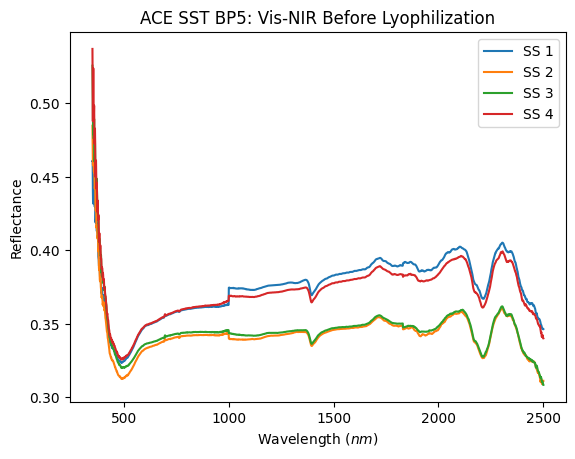

In [887]:
plot_vis_nir_before(sample='ACE SST BP5', showAll=True)

Choosing SS 3 - smallest spectral joins

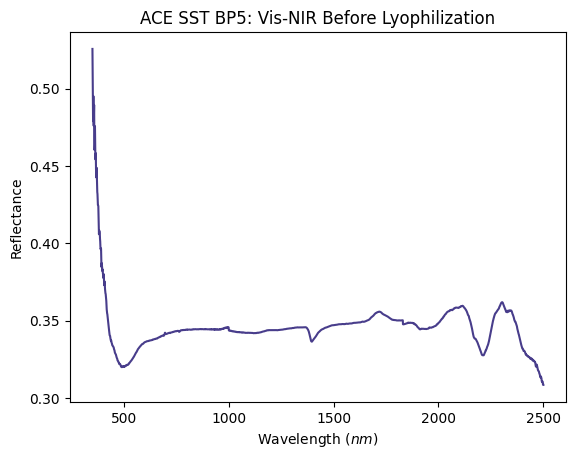

In [888]:
SELECTED_SUBSAMPLES['BEFORE_VIS_NIR']['ACE SST BP5'] = 3
plot_vis_nir_before(sample='ACE SST BP5')

#### ACE SST BP6

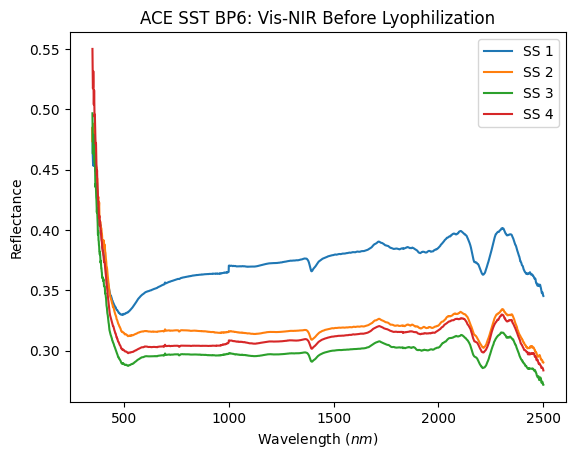

In [889]:
plot_vis_nir_before(sample='ACE SST BP6', showAll=True)

Choosing SS 2 - smallest spectral joins

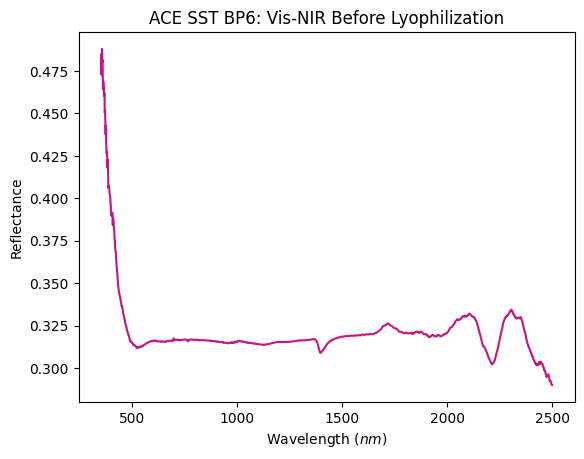

In [890]:
SELECTED_SUBSAMPLES['BEFORE_VIS_NIR']['ACE SST BP6'] = 2
plot_vis_nir_before(sample='ACE SST BP6')

#### ACE SST BLACK

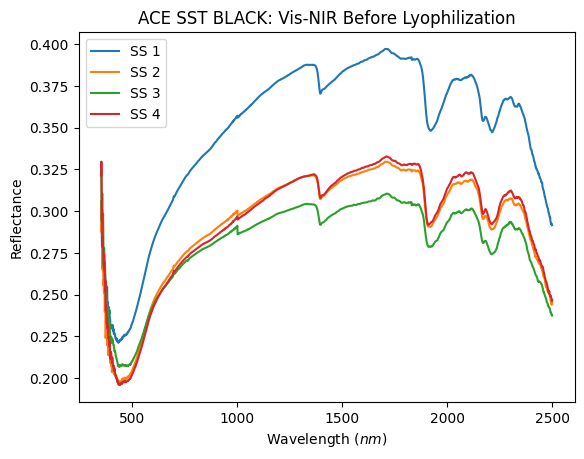

In [891]:
plot_vis_nir_before(sample='ACE SST BLACK', showAll=True)

Choosing SS 4 - smallest spectral joins and reflectance more similar to other subsamples compared to SS 1

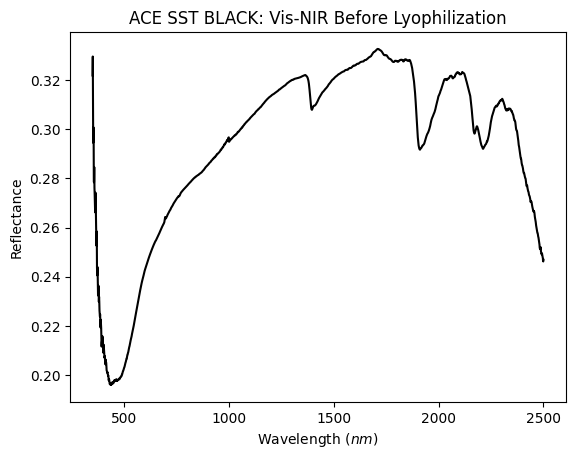

In [892]:
SELECTED_SUBSAMPLES['BEFORE_VIS_NIR']['ACE SST BLACK'] = 4
plot_vis_nir_before(sample='ACE SST BLACK')

#### SCOTT MAT

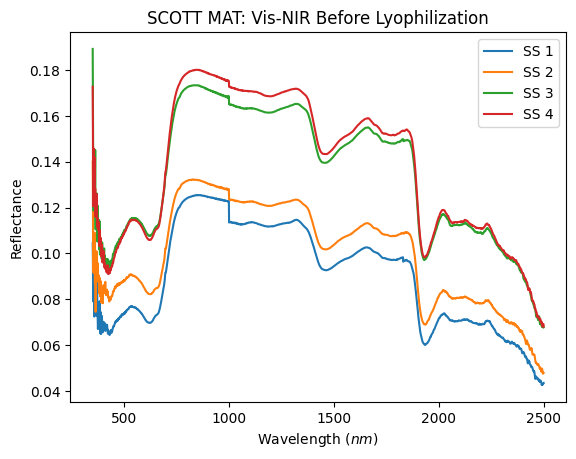

In [893]:
plot_vis_nir_before(sample='SCOTT MAT', showAll=True)

Choosing SS 4 - smallest spectral joins

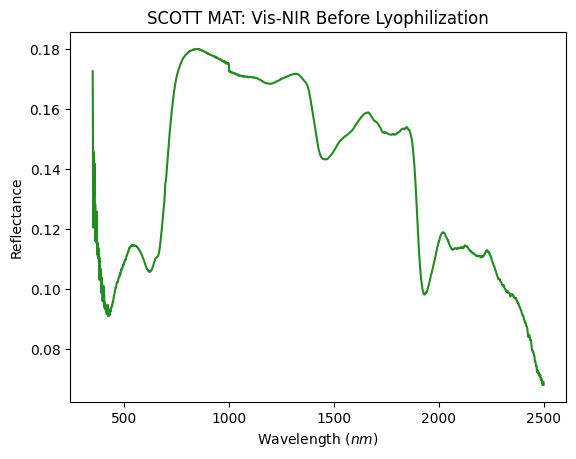

In [894]:
SELECTED_SUBSAMPLES['BEFORE_VIS_NIR']['SCOTT MAT'] = 4
plot_vis_nir_before(sample='SCOTT MAT')

Peak around 500nm consistent with presence of cholorphyll (green pigment) - green region of visible light is 495 - 570.

#### SOPHIA

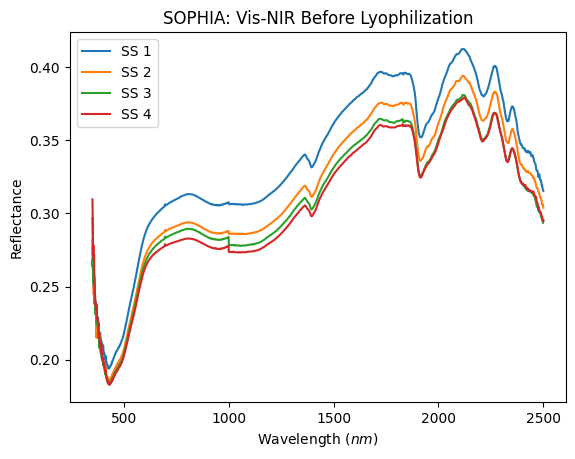

In [895]:
plot_vis_nir_before(sample='SOPHIA', showAll=True)

Choosing SS 1 - smallest spectral joins

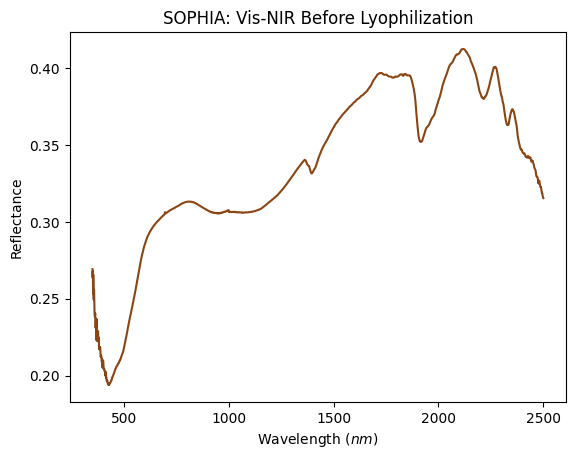

In [896]:
SELECTED_SUBSAMPLES['BEFORE_VIS_NIR']['SOPHIA'] = 1
plot_vis_nir_before(sample='SOPHIA')

<a href="https://oro.open.ac.uk/88399/1/1-s2.0-S0019103523001458-main.pdf">NIR spectra for SOPHIA</a>:

* 1.92 and 2.3 μm associated with hydration
* absorption at 2.5 μm is possibly due to the mixing of vermiculite with siderite and/or serpentine

#### SOPHIA MAT

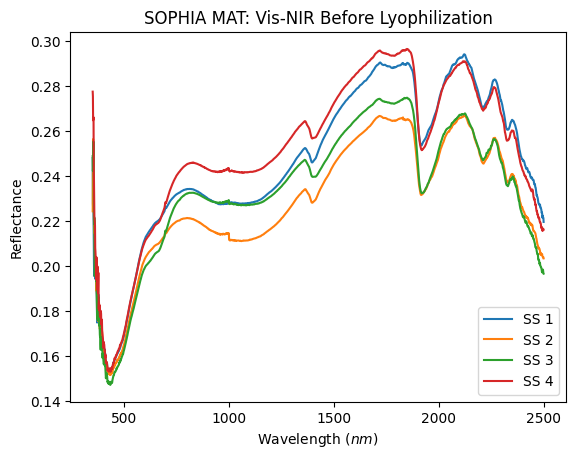

In [897]:
plot_vis_nir_before(sample='SOPHIA MAT', showAll=True)

Choosing SS 3 - smallest spectral joins

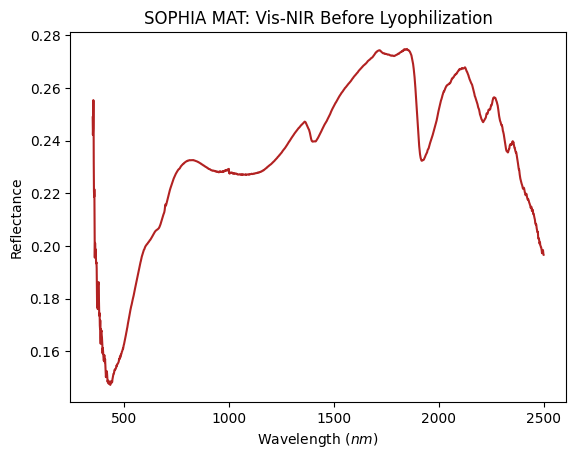

In [898]:
SELECTED_SUBSAMPLES['BEFORE_VIS_NIR']['SOPHIA MAT'] = 3
plot_vis_nir_before(sample='SOPHIA MAT')

### After Lyophilization

In [899]:
def plot_vis_nir_after(sample, showAll=False):
    plot_sample(sample=sample, isMIR=False, isBefore=False, showAll=showAll)

#### ACE SST BP5

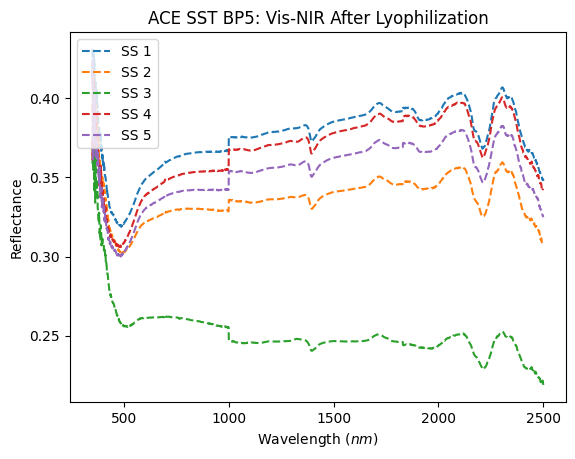

In [900]:
plot_vis_nir_after(sample='ACE SST BP5', showAll=True)

Choosing SS 2 - smallest spectral joins

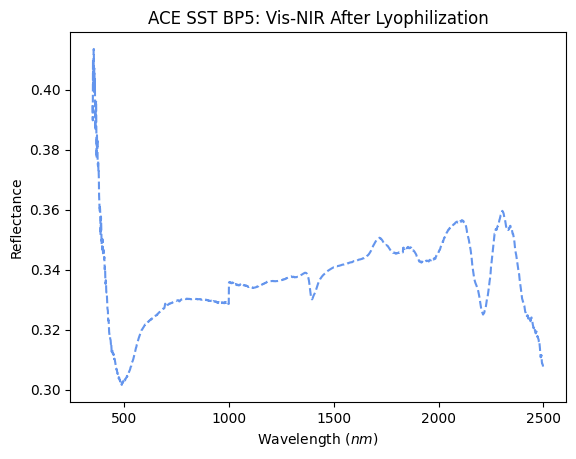

In [901]:
SELECTED_SUBSAMPLES['AFTER_VIS_NIR']['ACE SST BP5'] = 2
plot_vis_nir_after(sample='ACE SST BP5')

#### ACE SST BP6

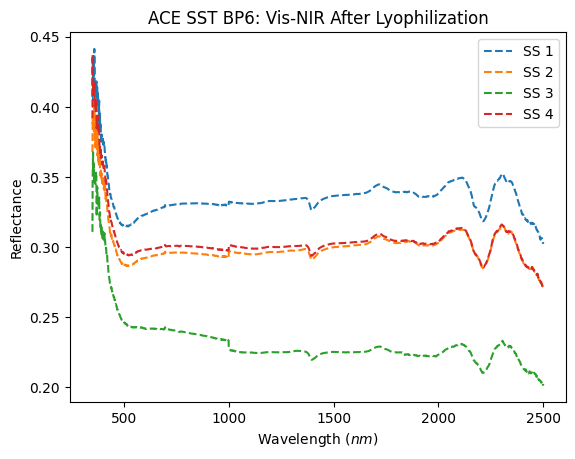

In [902]:
plot_vis_nir_after(sample='ACE SST BP6', showAll=True)

Choosing SS 4 - smallest spectral joins and small feature around 700nm

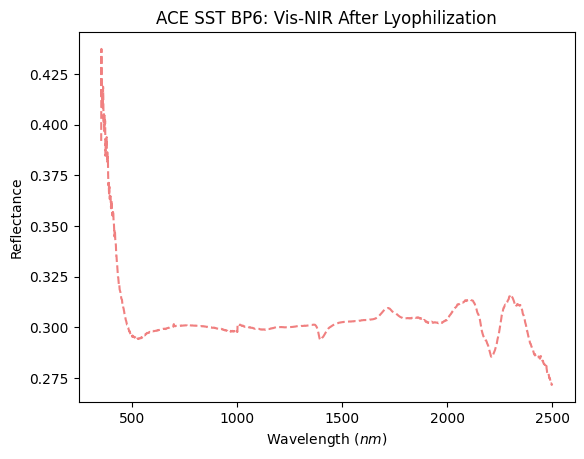

In [903]:
SELECTED_SUBSAMPLES['AFTER_VIS_NIR']['ACE SST BP6'] = 4
plot_vis_nir_after(sample='ACE SST BP6')

#### ACE SST BLACK

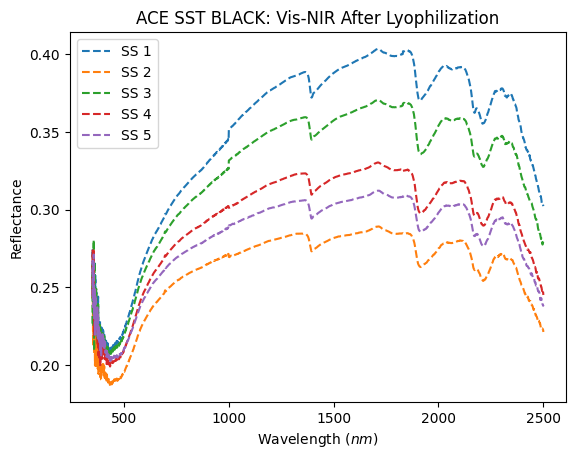

In [904]:
plot_vis_nir_after(sample='ACE SST BLACK', showAll=True)

Choosing SS 4 - smallest spectral joins

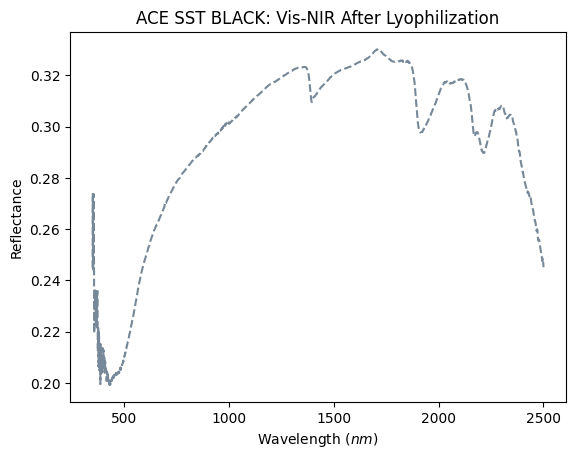

In [905]:
SELECTED_SUBSAMPLES['AFTER_VIS_NIR']['ACE SST BLACK'] = 4
plot_vis_nir_after(sample='ACE SST BLACK')

#### SCOTT MAT

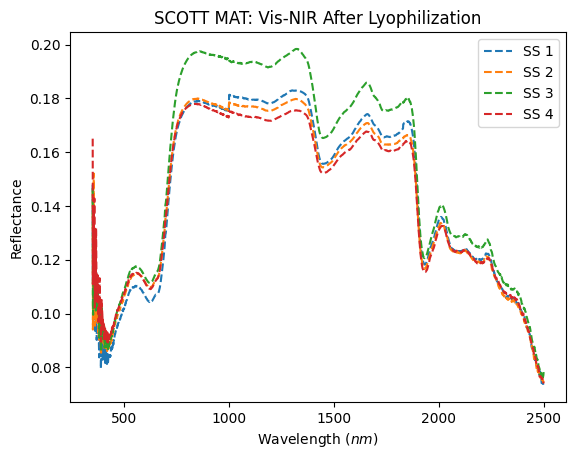

In [906]:
plot_vis_nir_after(sample='SCOTT MAT', showAll=True)

Choosing SS 3 - smallest spectral joins

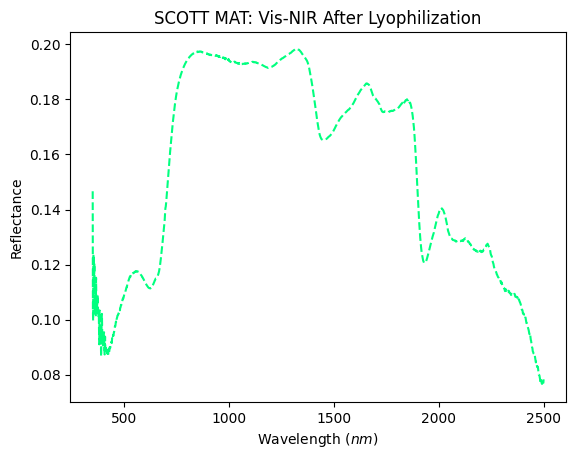

In [907]:
SELECTED_SUBSAMPLES['AFTER_VIS_NIR']['SCOTT MAT'] = 3
plot_vis_nir_after(sample='SCOTT MAT')

#### SOPHIA

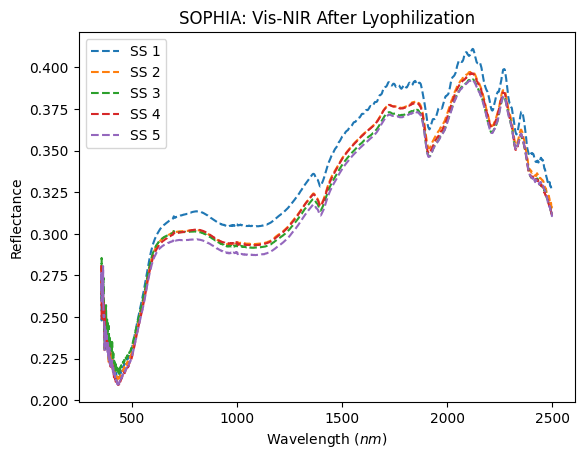

In [908]:
plot_vis_nir_after(sample='SOPHIA', showAll=True)

Choosing SS 1 - features are more prominent

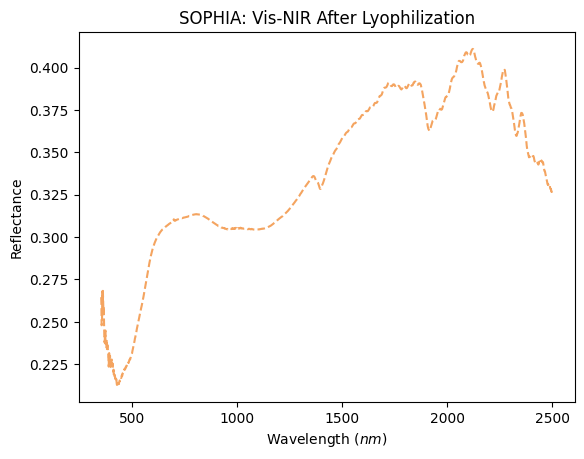

In [909]:
SELECTED_SUBSAMPLES['AFTER_VIS_NIR']['SOPHIA'] = 1
plot_vis_nir_after(sample='SOPHIA')

#### SOPHIA MAT

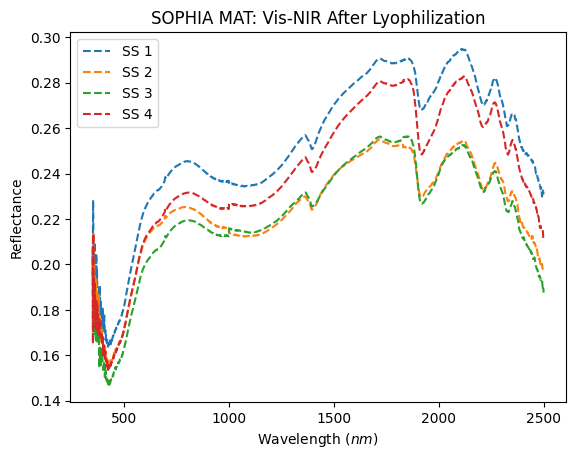

In [910]:
plot_vis_nir_after(sample='SOPHIA MAT', showAll=True)

Choosing SS 1 - smallest spectral joins

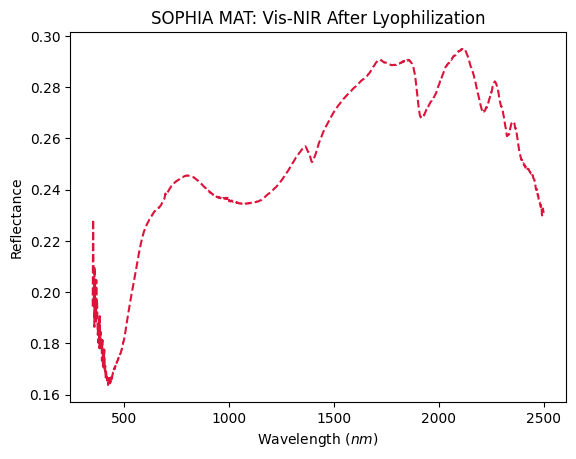

In [911]:
SELECTED_SUBSAMPLES['AFTER_VIS_NIR']['SOPHIA MAT'] = 1
plot_vis_nir_after(sample='SOPHIA MAT')

### Lyophilization Effects

#### ACE SST BP5

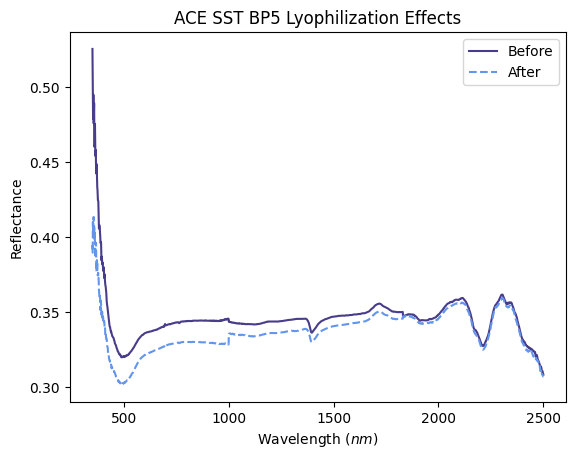

In [912]:
compare_subsamples(sample_A='ACE SST BP5', sample_A_isBefore=True, isMIR=False)

#### ACE SST BP6

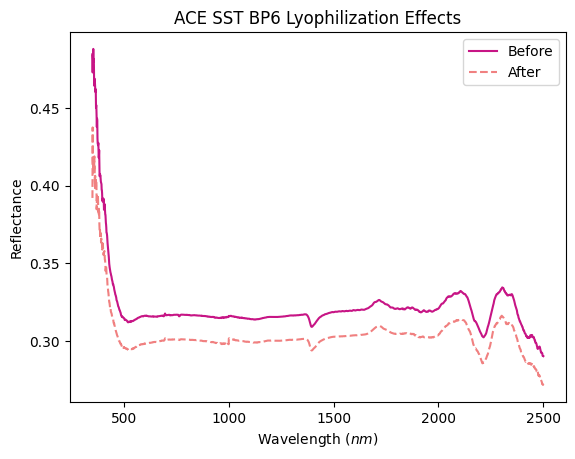

In [913]:
compare_subsamples(sample_A='ACE SST BP6', sample_A_isBefore=True, isMIR=False)

#### ACE SST BLACK

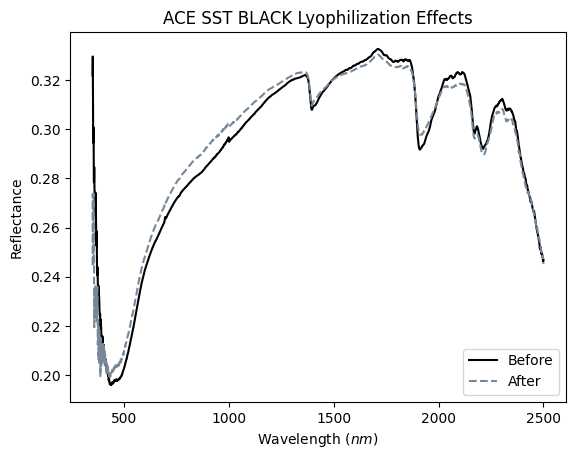

In [914]:
compare_subsamples(sample_A='ACE SST BLACK', sample_A_isBefore=True, isMIR=False)

#### SCOTT MAT

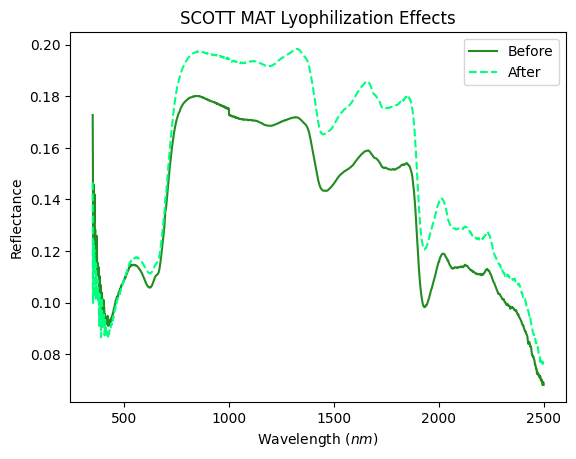

In [915]:
compare_subsamples(sample_A='SCOTT MAT', sample_A_isBefore=True, isMIR=False)

#### SOPHIA

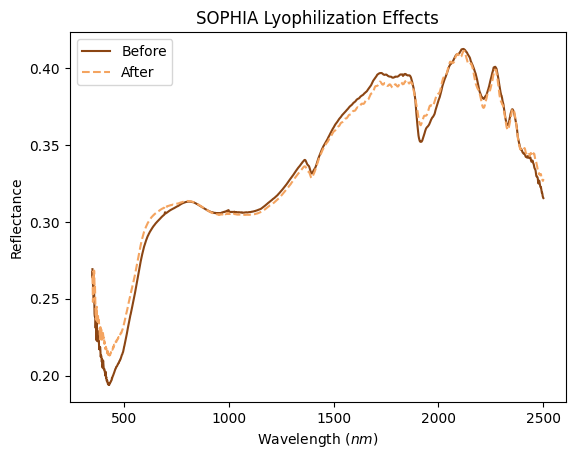

In [916]:
compare_subsamples(sample_A='SOPHIA', sample_A_isBefore=True, isMIR=False)

#### SOPHIA MAT

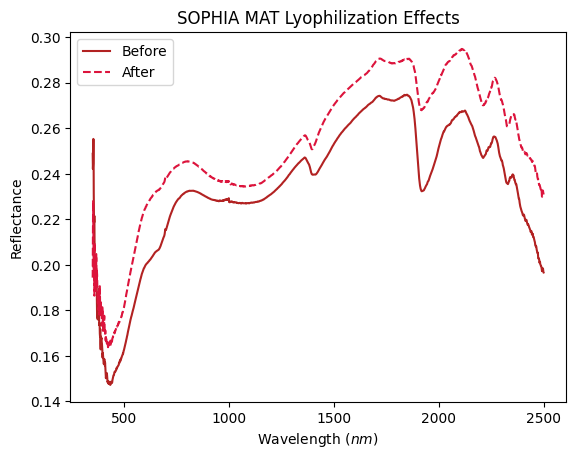

In [917]:
compare_subsamples(sample_A='SOPHIA MAT', sample_A_isBefore=True, isMIR=False)

### ACE SST Analysis

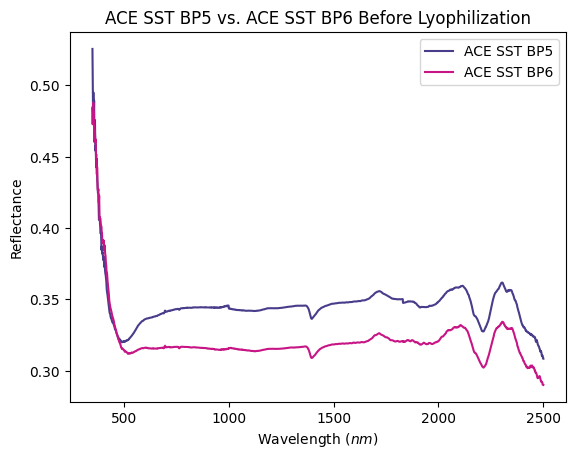

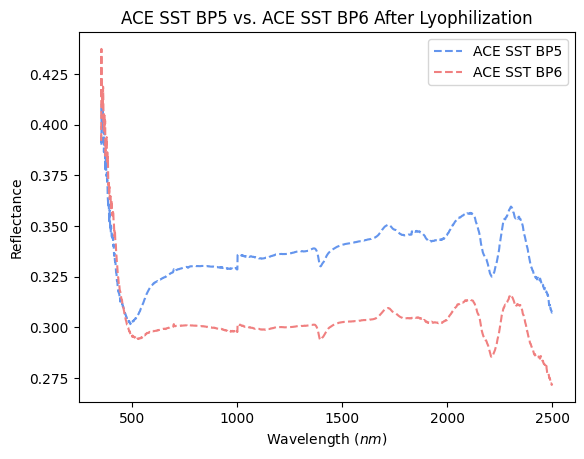

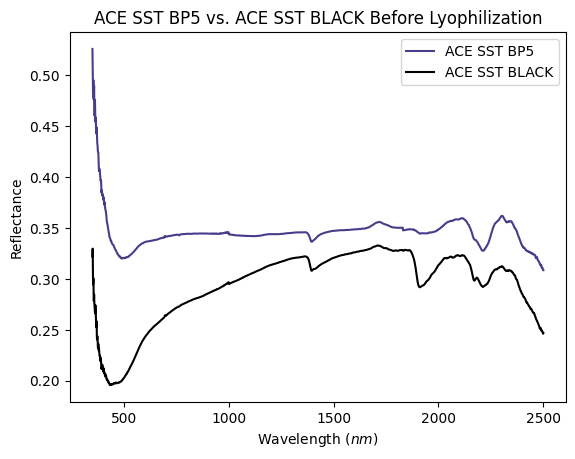

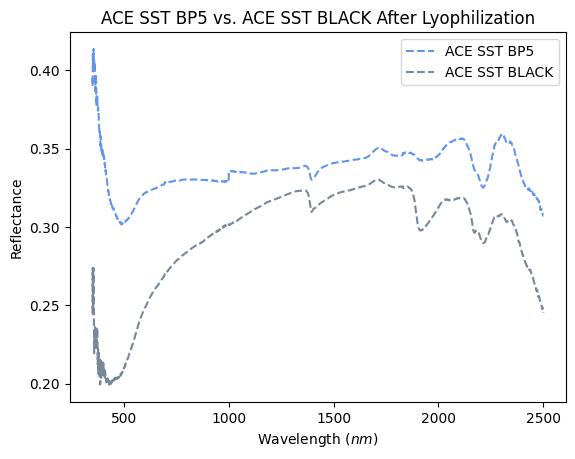

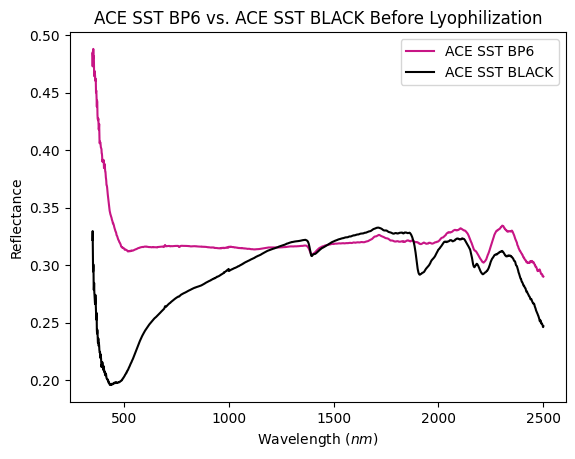

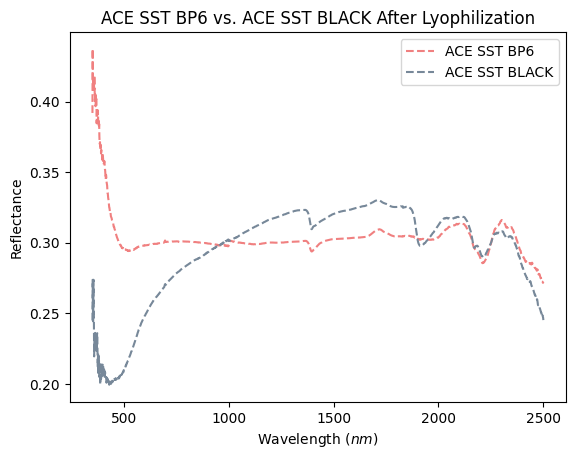

In [918]:
compare_subsamples(sample_A='ACE SST BP5', sample_B='ACE SST BP6', sample_A_isBefore=True, sample_B_isBefore=True, isMIR=False)
compare_subsamples(sample_A='ACE SST BP5', sample_B='ACE SST BP6', sample_A_isBefore=False, sample_B_isBefore=False, isMIR=False)
compare_subsamples(sample_A='ACE SST BP5', sample_B='ACE SST BLACK', sample_A_isBefore=True, sample_B_isBefore=True, isMIR=False)
compare_subsamples(sample_A='ACE SST BP5', sample_B='ACE SST BLACK', sample_A_isBefore=False, sample_B_isBefore=False, isMIR=False)
compare_subsamples(sample_A='ACE SST BP6', sample_B='ACE SST BLACK', sample_A_isBefore=True, sample_B_isBefore=True, isMIR=False)
compare_subsamples(sample_A='ACE SST BP6', sample_B='ACE SST BLACK', sample_A_isBefore=False, sample_B_isBefore=False, isMIR=False)

### SOPHIA Analysis

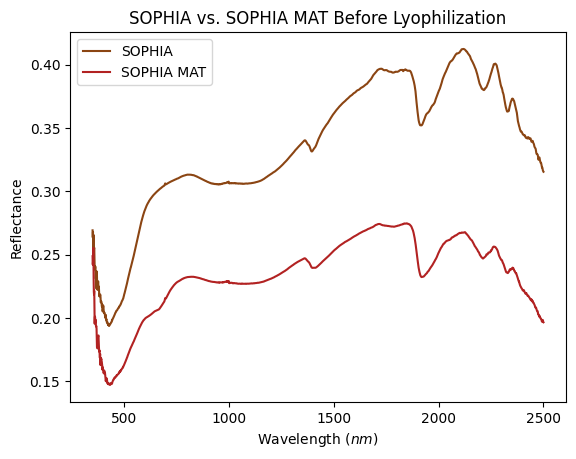

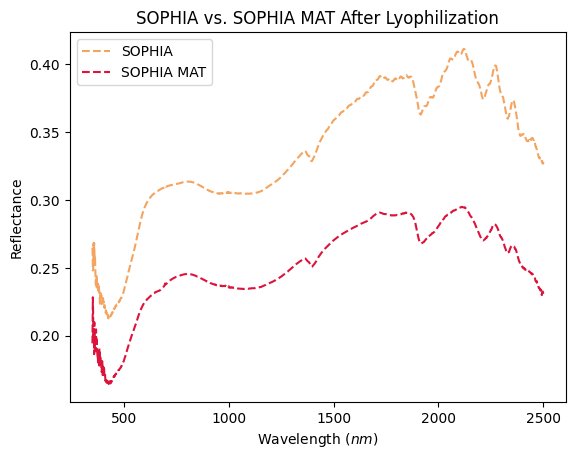

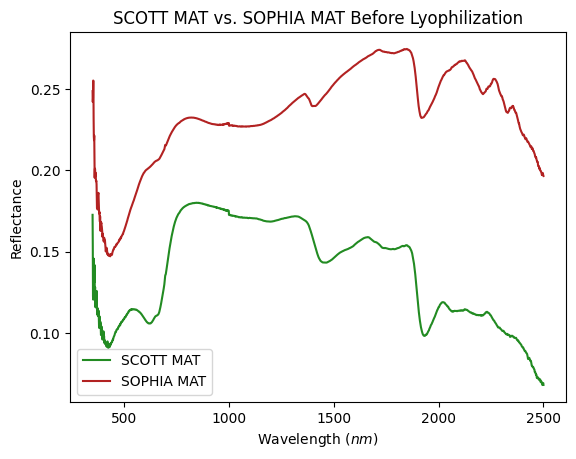

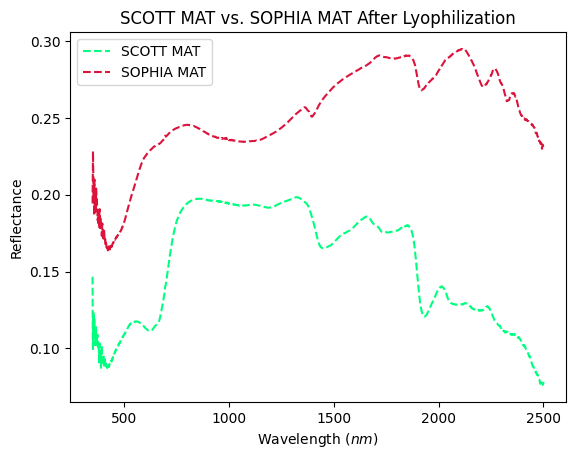

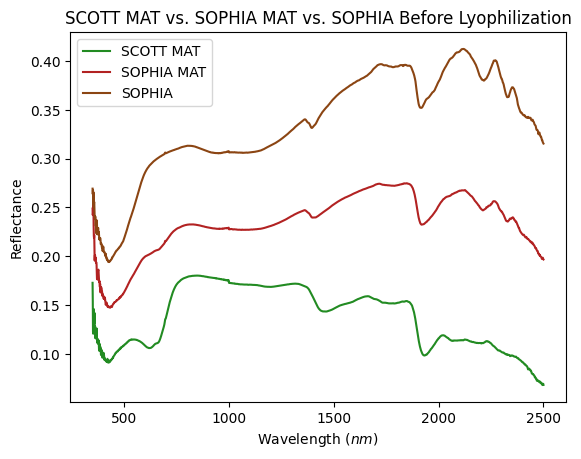

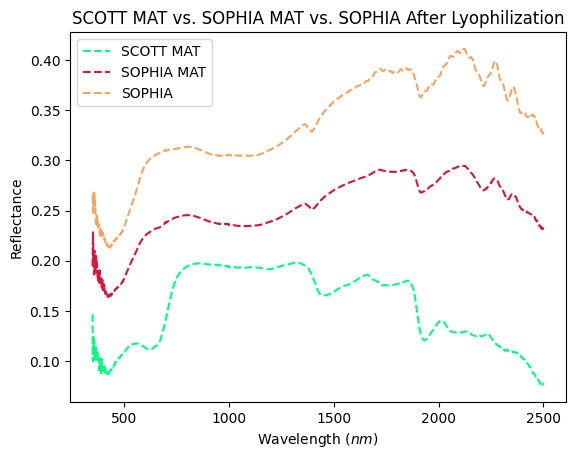

In [919]:
compare_subsamples(sample_A='SOPHIA', sample_B='SOPHIA MAT', sample_A_isBefore=True, sample_B_isBefore=True, isMIR=False)
compare_subsamples(sample_A='SOPHIA', sample_B='SOPHIA MAT', sample_A_isBefore=False, sample_B_isBefore=False, isMIR=False)
compare_subsamples(sample_A='SCOTT MAT', sample_B='SOPHIA MAT', sample_A_isBefore=True, sample_B_isBefore=True, isMIR=False)
compare_subsamples(sample_A='SCOTT MAT', sample_B='SOPHIA MAT', sample_A_isBefore=False, sample_B_isBefore=False, isMIR=False)
compare_subsamples(sample_A='SCOTT MAT', sample_B='SOPHIA MAT', sample_C='SOPHIA', sample_A_isBefore=True, sample_B_isBefore=True, sample_C_isBefore=True, isMIR=False)
compare_subsamples(sample_A='SCOTT MAT', sample_B='SOPHIA MAT', sample_C='SOPHIA', sample_A_isBefore=False, sample_B_isBefore=False, sample_C_isBefore=False, isMIR=False)